In [147]:
import docx
import os
import json
import pandas as pd
import psymarkers
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
local_PATH = './local/'
online_PATH = './online/'
data = []
for source in [local_PATH, online_PATH]:
    if source == local_PATH:
        src = 'очно'
    if source == online_PATH:
        src = 'онлайн'
    dirfiles = [i for i in os.listdir(source) if i.endswith('.docx') or i.endswith('.doc')]
    for docname in dirfiles:
        res = {}
        res['Тип'] = src
        res['Документ'] = docname[:-5]
        
        filepath = source+docname
        doc = docx.Document(filepath)
        
        res['Т:'] = []
        res['К:'] = []
        
        dialog_started = False
        for para in [i for i in doc.paragraphs if len(i.text)>0]:
            if para.text.startswith(('Т:','К:')):

                if dialog_started:
                    res[current_speaker].append(speaker_text)

                dialog_started = True
                current_speaker = para.text[:2]
                speaker_text = para.text
            elif dialog_started:
                speaker_text += ' ' + para.text
        res[current_speaker].append(speaker_text)
        data.append(res)

In [4]:
text_data = []
for i in data:
    K_res = {}
    K_res['Тип встречи'] = i['Тип']
    K_res['Документ'] = i['Документ']
    K_res['Роль'] = 'Клиент'
    K_res['Текст'] = ' '.join(i['К:']).replace('К:','')
    K_res['Число реплик'] = len(i['К:'])
    
    T_res = {}
    T_res['Тип встречи'] = i['Тип']
    T_res['Документ'] = i['Документ']
    T_res['Роль'] = 'Терапевт'
    T_res['Текст'] = ' '.join(i['Т:']).replace('Т:','')
    T_res['Число реплик'] = len(i['Т:'])
    
    text_data.append(K_res)
    text_data.append(T_res)

In [5]:
def getPM(proc, divider = 'word'):
    res = {}
    res.update(proc.getGeneralStat())
    res.update(proc.getPsyMarkers())
    res.update(proc.getDictFeatures(divider=divider))
    res.update(proc.getPostagFeatures(divider=divider))
    res.update(proc.getSemFeatures(divider=divider))
    res.update(proc.getSyntFeatures(divider=divider))
    res.update(proc.getLiwcFeatures(divider=divider))
    return res

In [ ]:
df_data = []
df_data_abs = []
for i_id,i in enumerate(text_data):
    print (i['Документ'], i['Роль'], i['Число реплик'], len(i['Текст']), end='')
    res = {}
    res['Роль'] = i['Роль']
    res['Тип встречи'] = i['Тип встречи']
    res['Документ'] = i['Документ']
    res['Число реплик'] = i['Число реплик']
    
    res_abs = {}
    res_abs['Роль'] = i['Роль']
    res_abs['Тип встречи'] = i['Тип встречи']
    res_abs['Документ'] = i['Документ']
    res_abs['Число реплик'] = i['Число реплик']
    
    proc = psymarkers.PsyMarkersTool()
    proc.process(i['Текст'], use_liwc=True, max_text_chunk=4000)
    res.update(getPM(proc))
    df_data.append(res)
    
    res_abs.update(getPM(proc, divider='abs'))
    df_data_abs.append(res_abs)
    
    print(' ...Done')

In [7]:
df_PM = pd.DataFrame(df_data)
df_PM_abs = pd.DataFrame(df_data_abs)

In [8]:
df_PM['Тональность текста'] = df_PM['Тональность слов (по усредненным значениям)'] / df_PM['Число слов']
df_PM_abs['Тональность текста'] = df_PM_abs['Тональность слов (по усредненным значениям)'] / df_PM_abs['Число слов']

In [9]:
# writer = pd.ExcelWriter('Маркеры.xlsx', engine='xlsxwriter')
# df.to_excel(writer, sheet_name='Нормализованные значения', index=False)
# writer.save()

In [26]:
online_T = df_PM.loc[(df_PM['Тип встречи'] == 'онлайн') & (df_PM['Роль'] == 'Терапевт')]
online_K = df_PM.loc[(df_PM['Тип встречи'] == 'онлайн') & (df_PM['Роль'] == 'Клиент')]
offline_T = df_PM.loc[(df_PM['Тип встречи'] == 'очно') & (df_PM['Роль'] == 'Терапевт')]
offline_K = df_PM.loc[(df_PM['Тип встречи'] == 'очно') & (df_PM['Роль'] == 'Клиент')]

features = list(df_PM.columns[3:])
all_types = {'Онлайн клиент':online_K, 'Очно клиент':offline_K, 'Онлайн терапевт':online_T, 'Очно терапевт':offline_T}

In [28]:
def normal_dist(l):
    stat,pval = stats.normaltest(l)
    if pval > 0.05:
        return True
    return False

In [29]:
def remove_outliers(feature, coef=2):
    q1 = feature.quantile(0.25)
    q3 = feature.quantile(0.75)
    IQR_coef = coef * (q3 - q1)
    low_boarder  = feature.quantile(0.25) - IQR_coef
    high_boarder = feature.quantile(0.75) + IQR_coef
    if len(feature[(feature>low_boarder)&(feature<high_boarder)]) > 0:
        return feature[(feature>low_boarder)&(feature<high_boarder)]
    else:
        return feature

In [159]:
def boxplot(data_to_plot, title, name1, name2):
    data_to_plot = [target1, target2]
    fig = plt.figure(1, figsize=(6, 5))
    ax = fig.add_subplot(111)
    ax.set_title(feature +' | pval '+res['pval mann-whitney'])
    ax.grid(True, axis='y')
    bp = ax.boxplot(data_to_plot, notch=False, showmeans=True, meanline=True, showfliers = True)
    ax.set_xticklabels([key1,key2])
    ax.set_ylabel(feature)    
    plt.show()

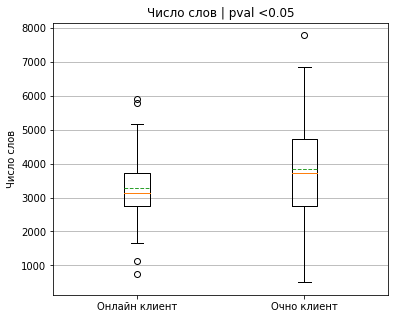

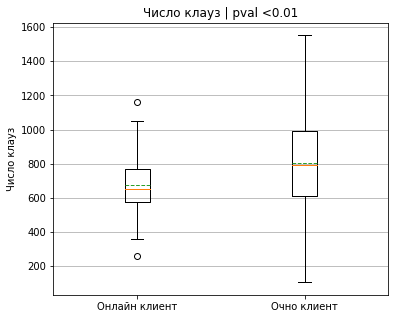

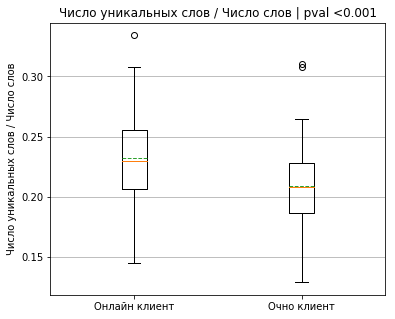

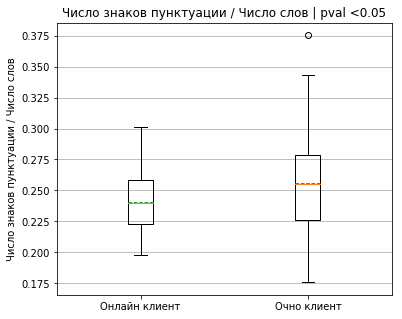

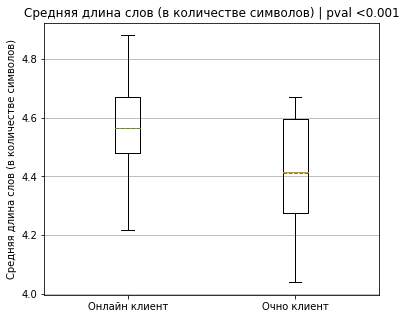

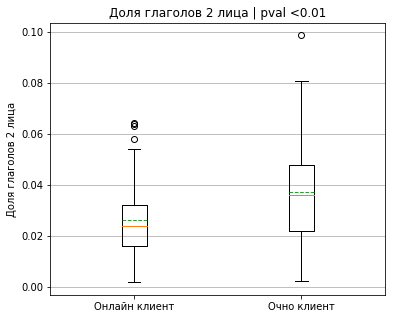

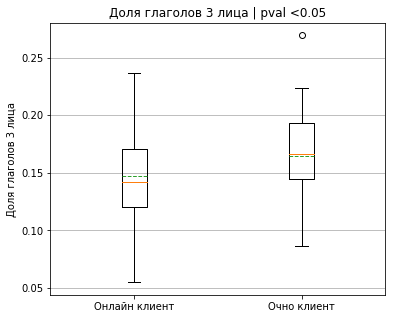

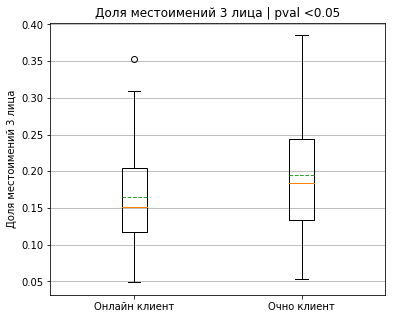

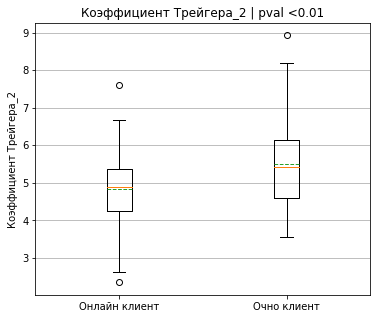

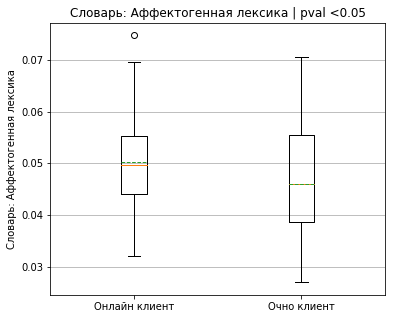

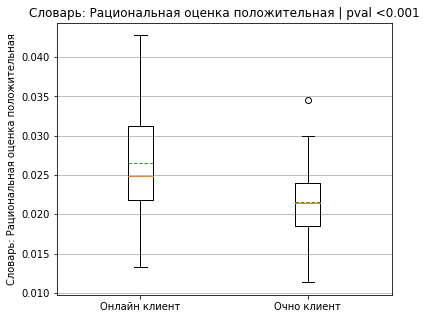

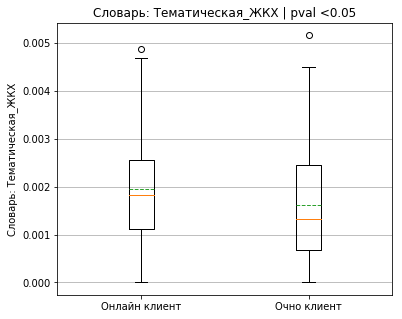

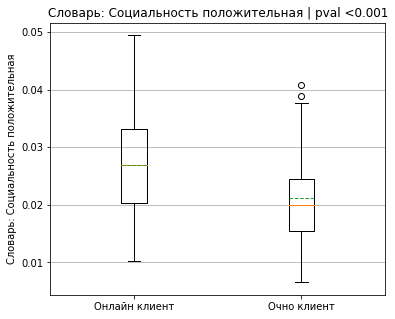

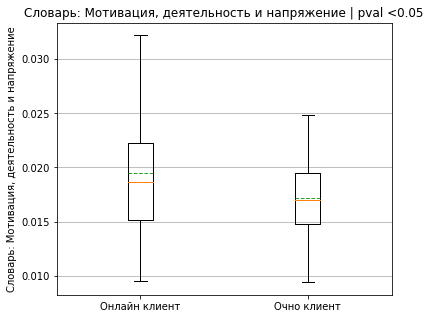

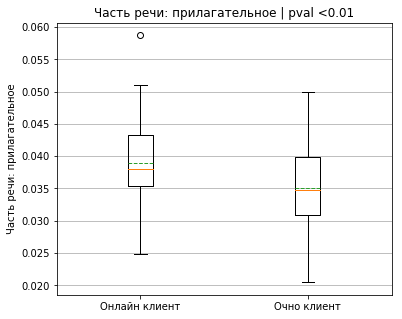

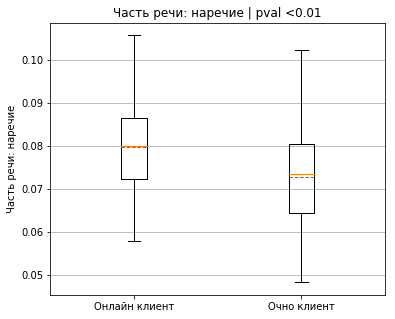

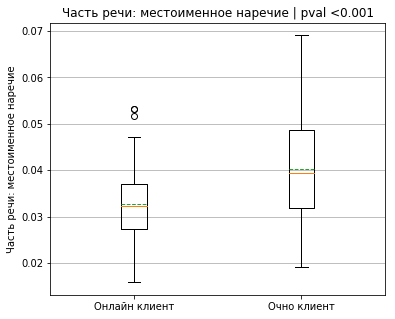

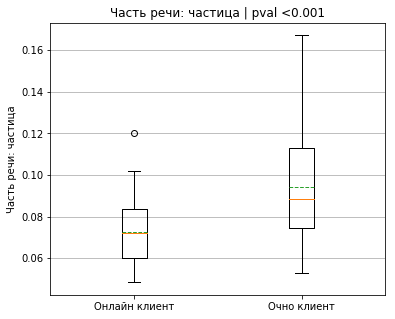

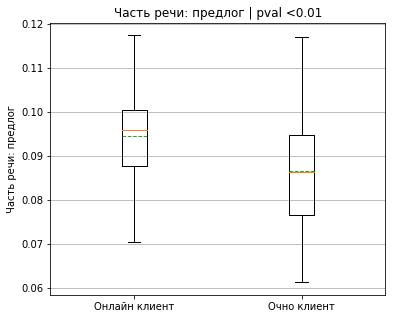

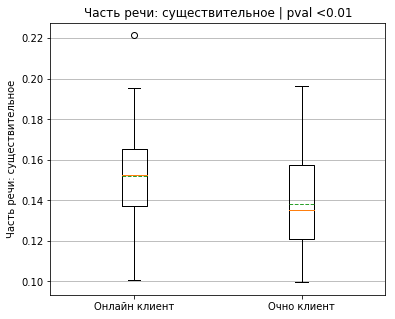

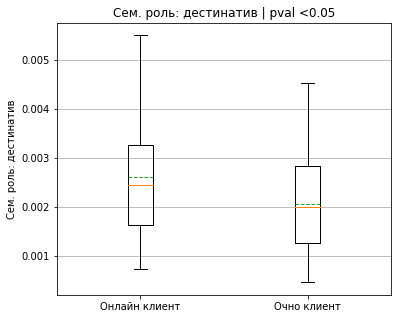

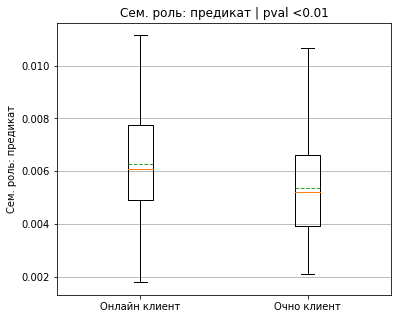

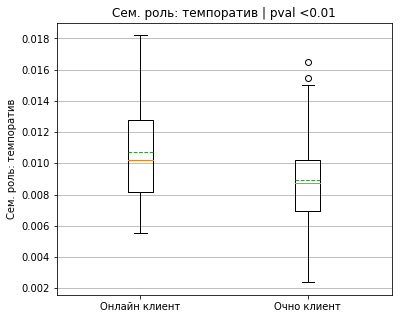

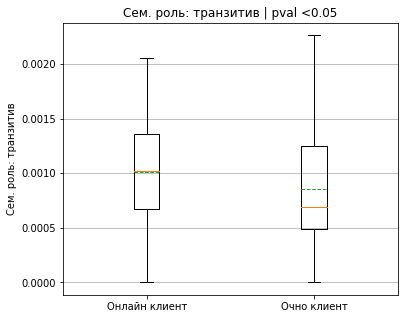

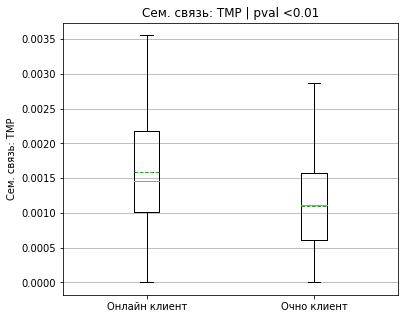

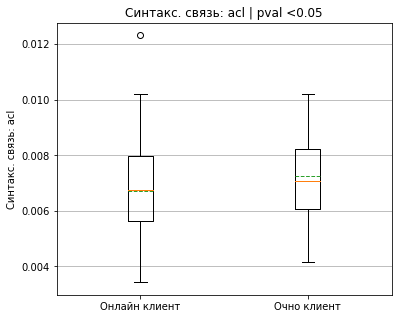

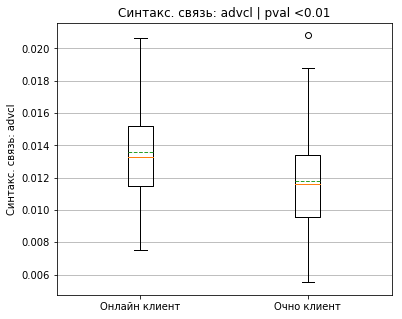

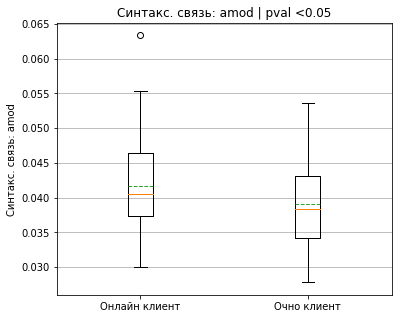

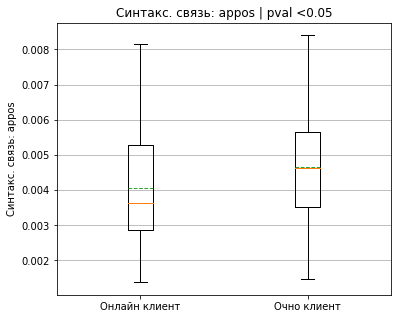

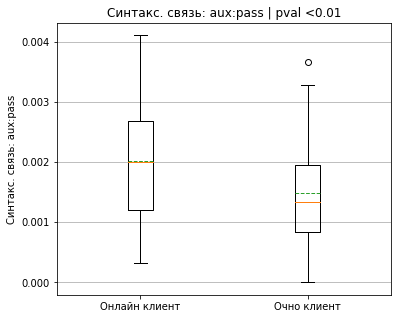

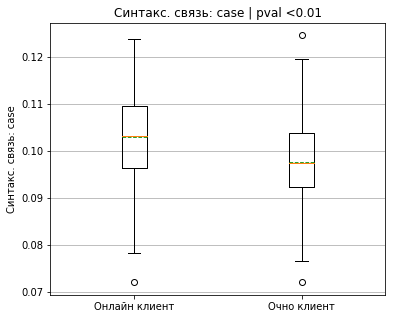

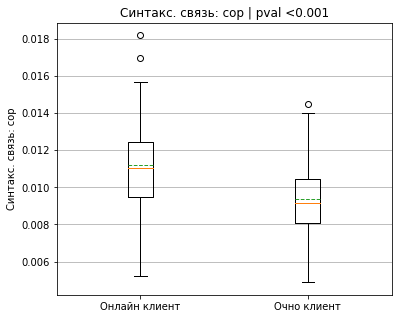

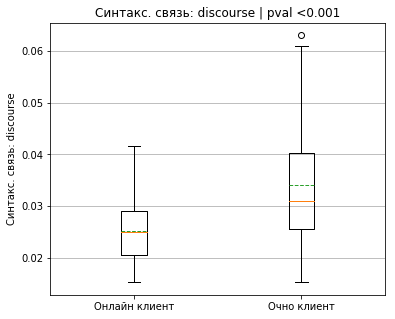

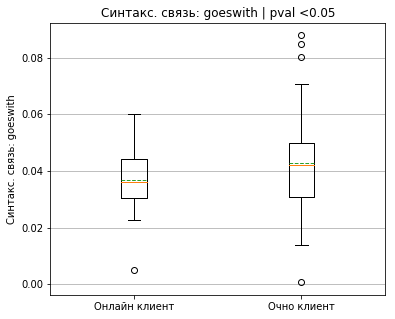

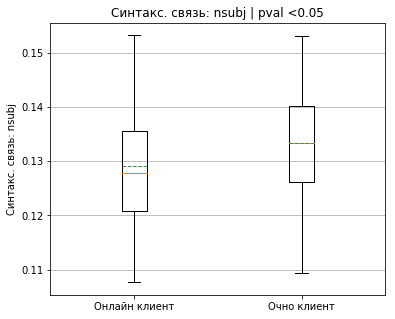

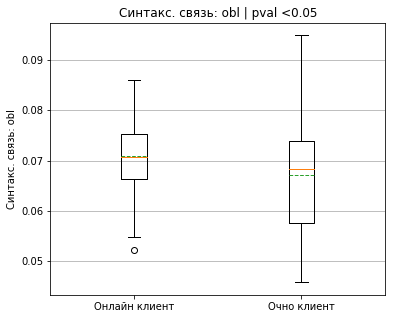

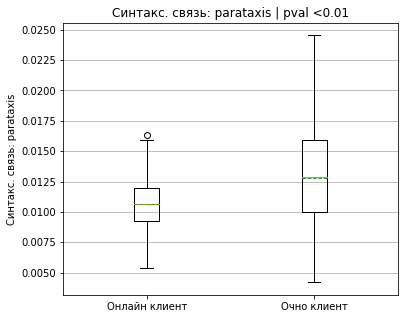

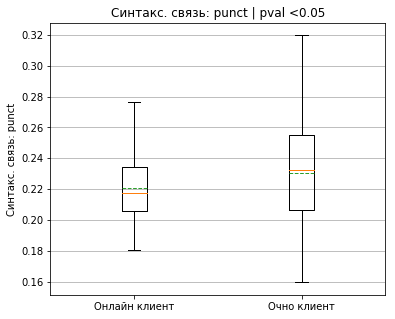

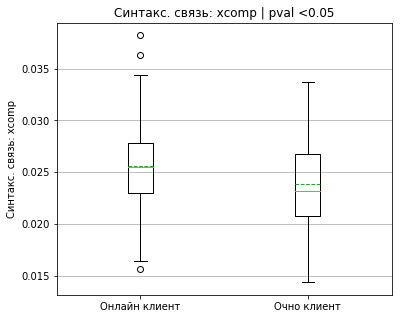

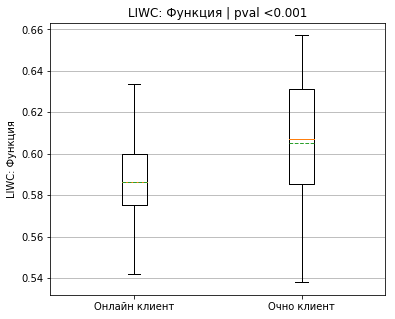

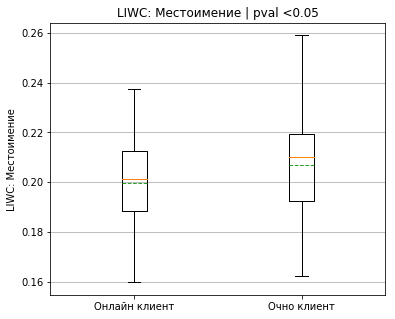

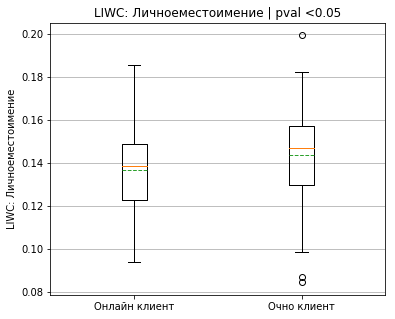

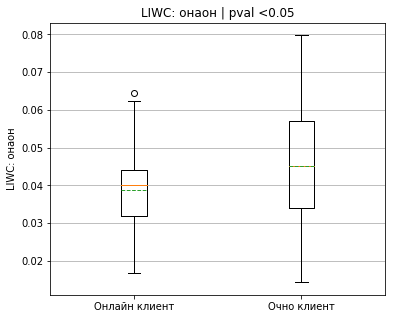

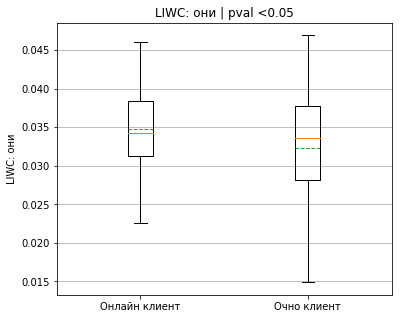

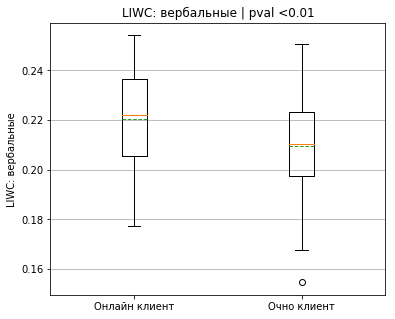

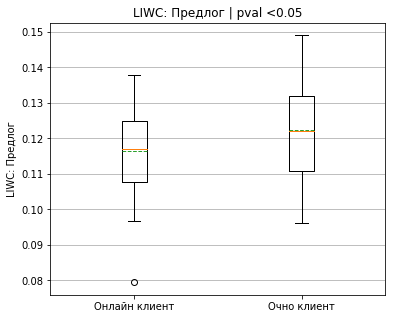

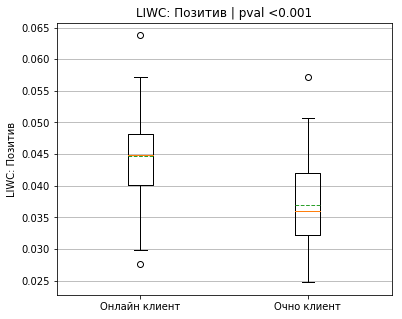

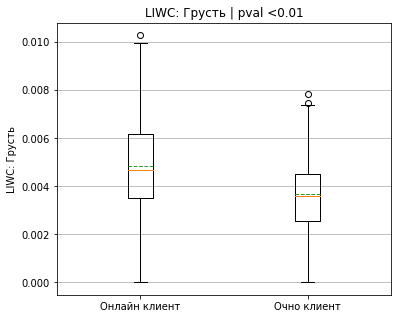

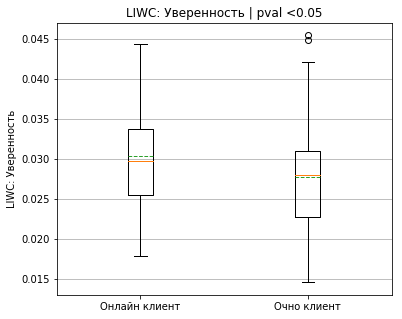

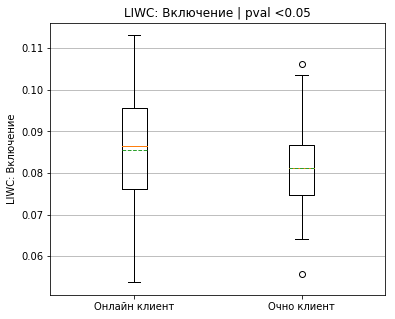

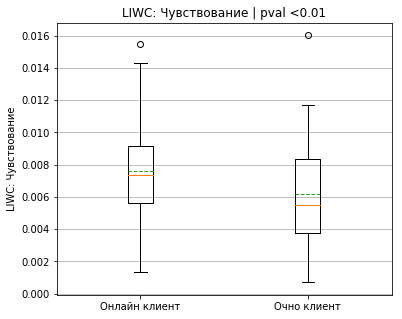

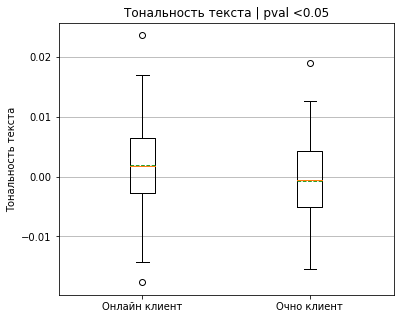

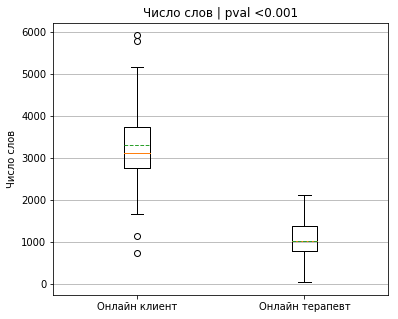

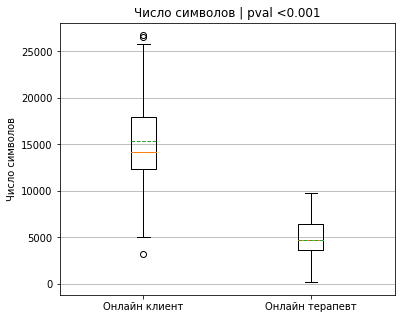

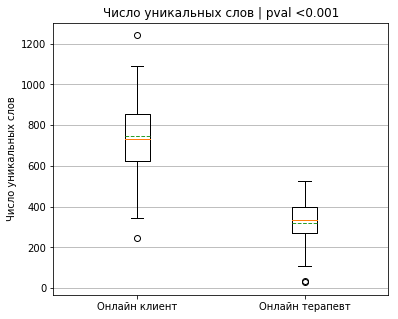

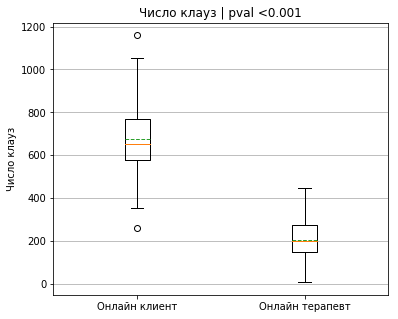

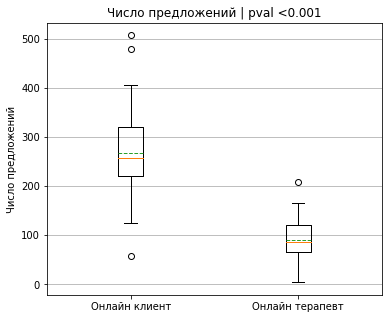

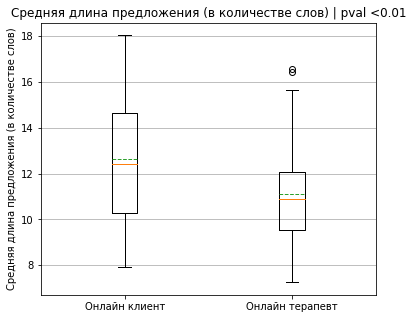

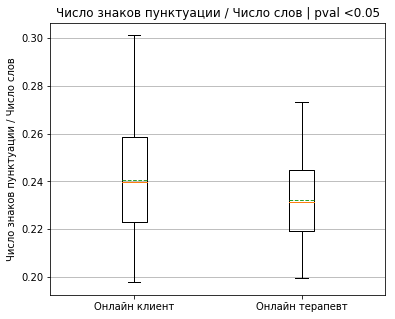

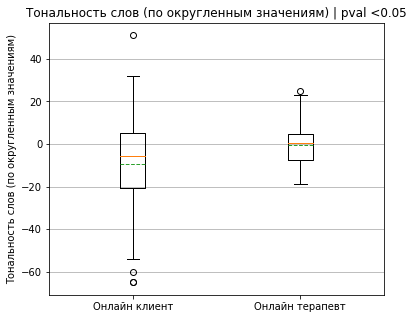

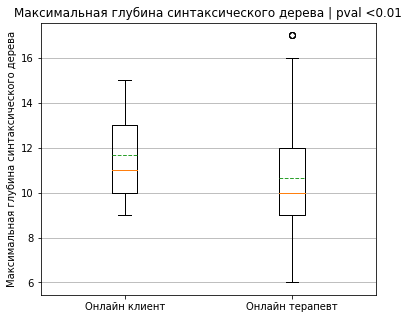

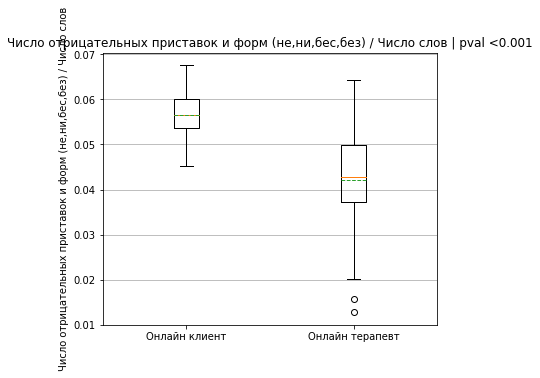

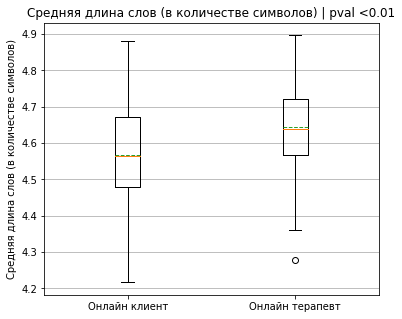

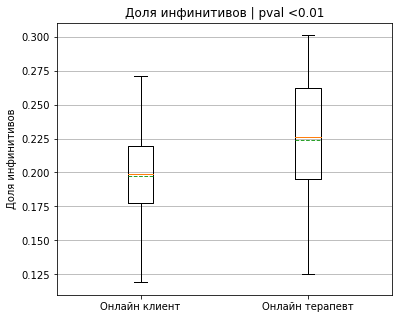

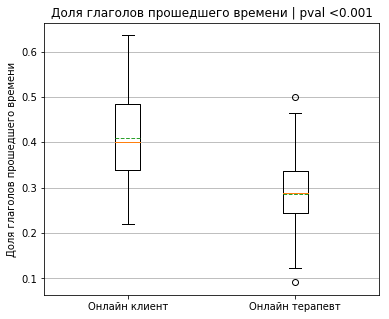

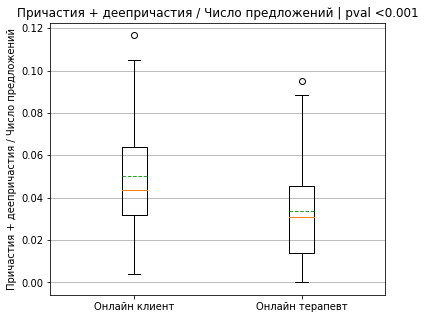

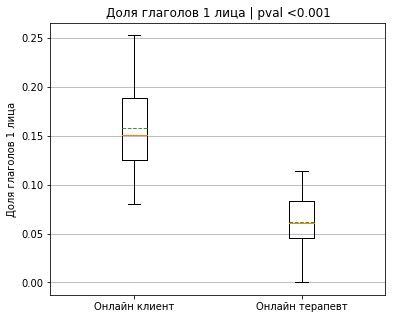

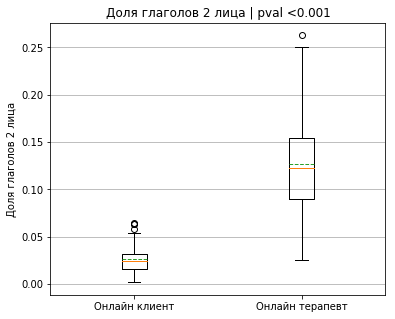

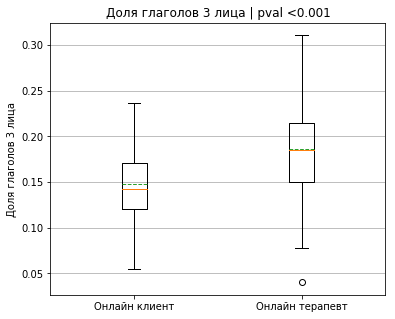

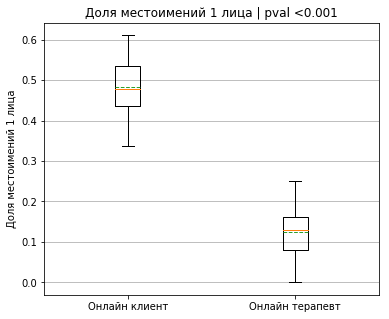

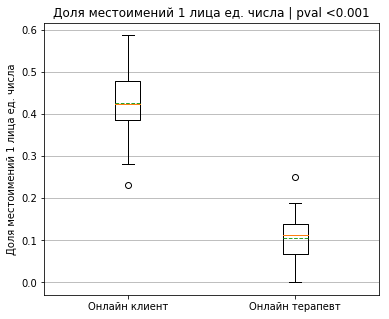

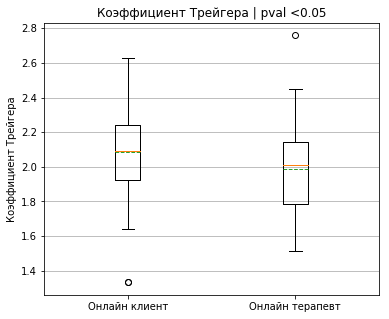

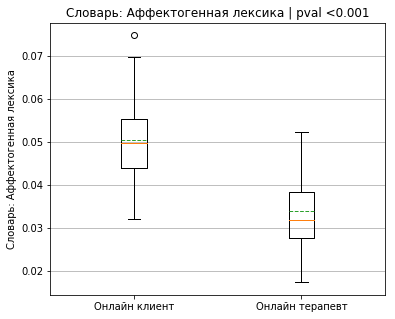

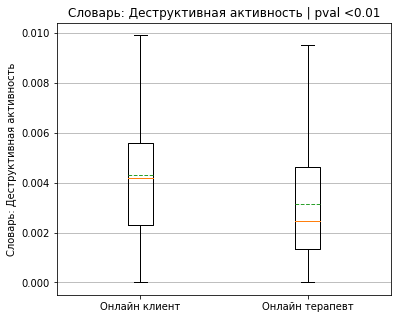

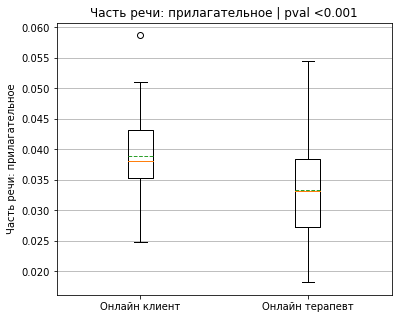

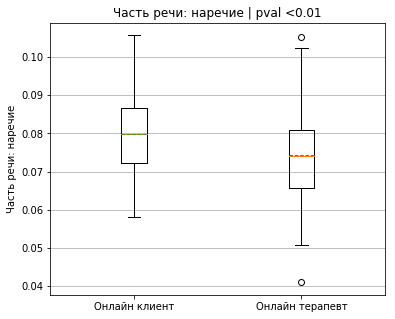

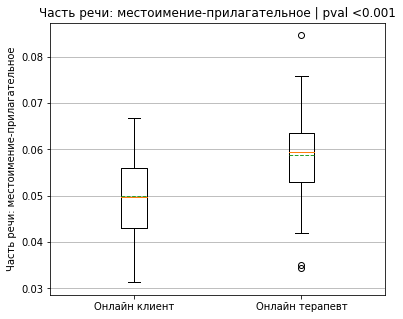

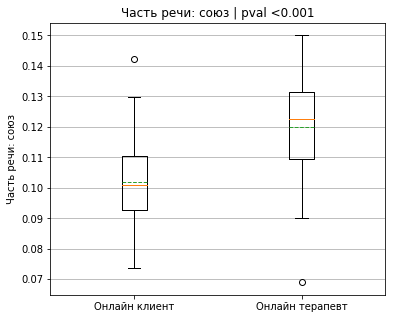

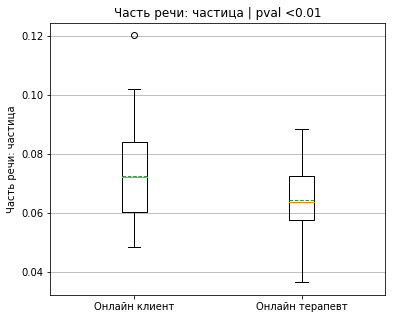

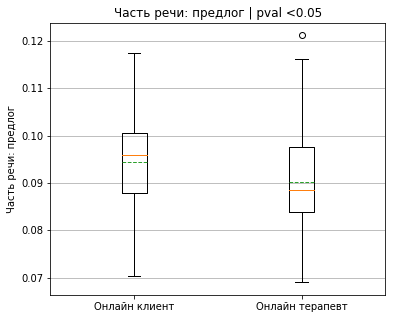

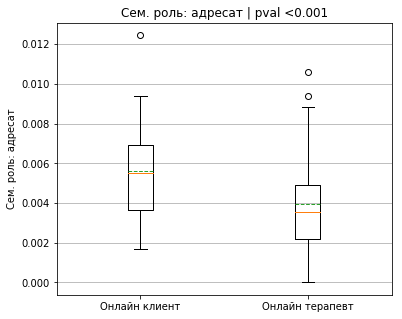

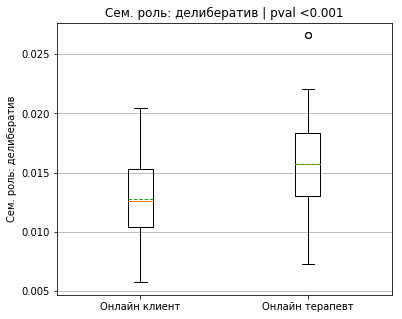

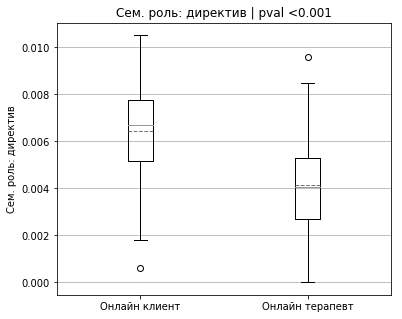

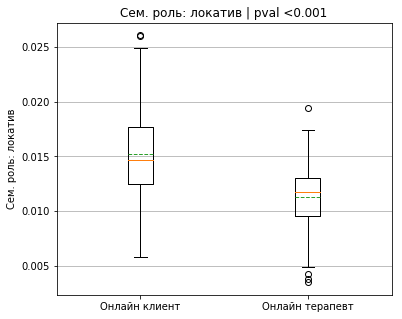

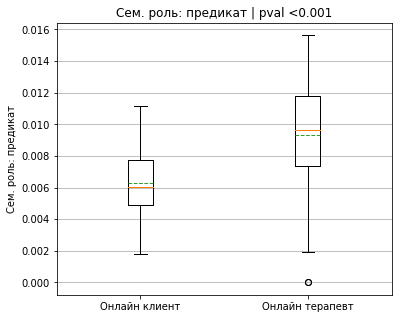

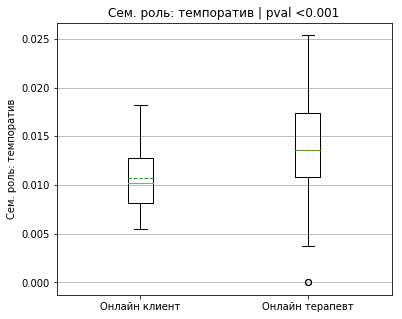

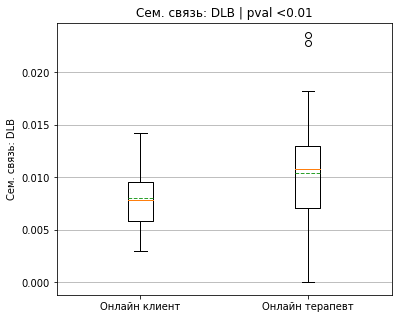

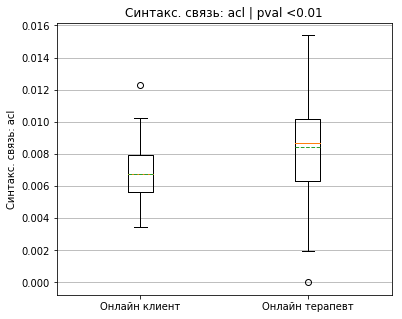

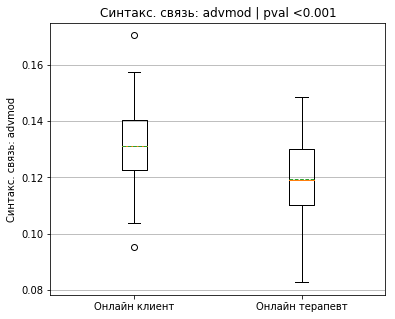

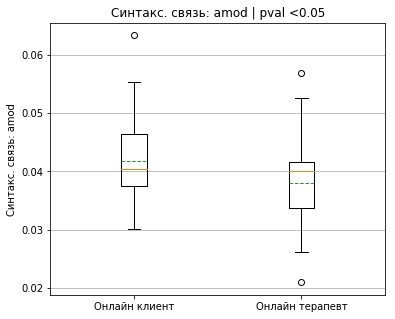

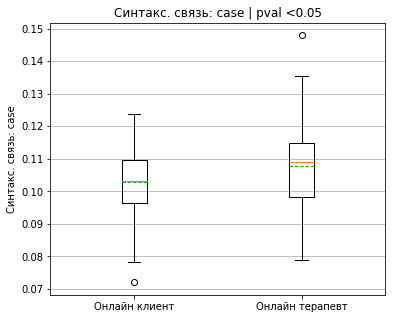

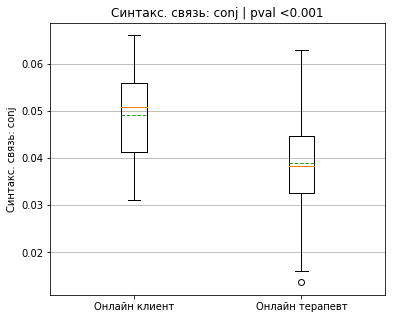

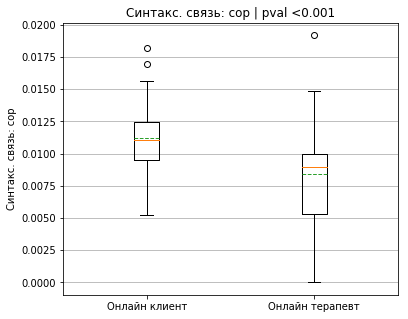

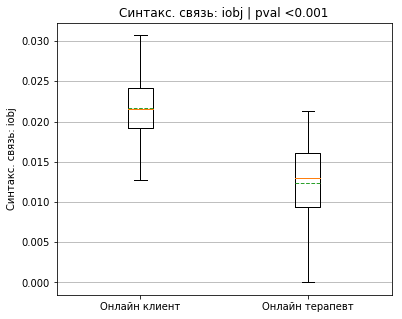

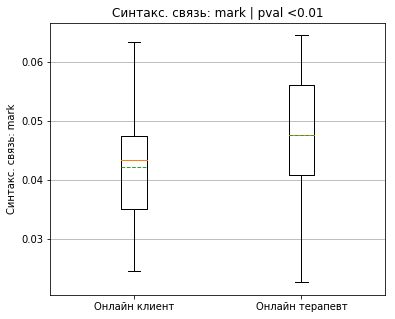

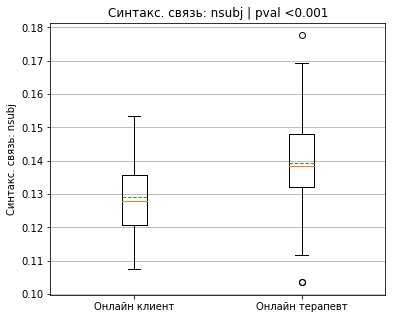

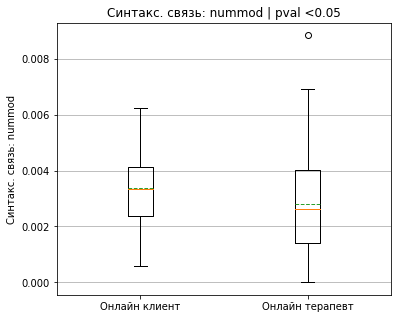

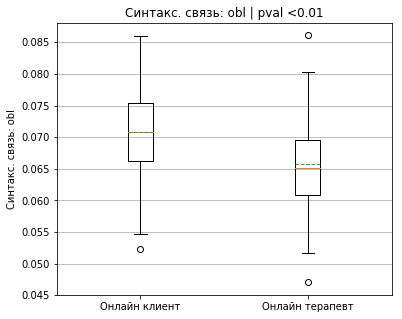

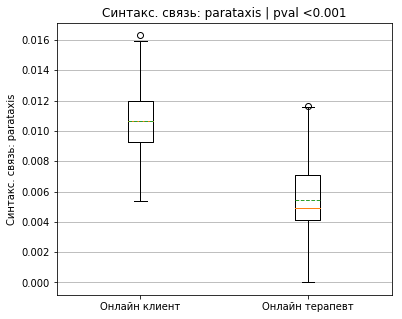

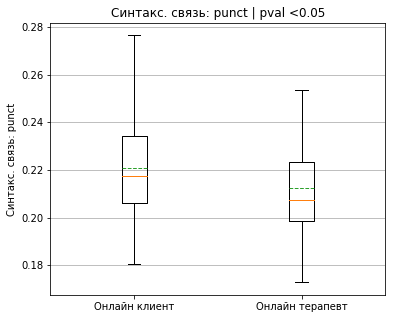

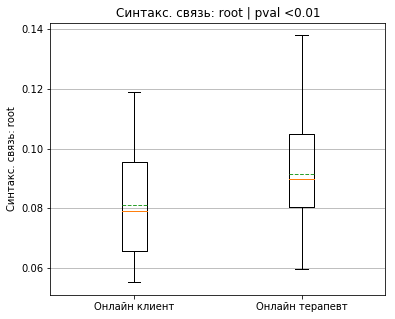

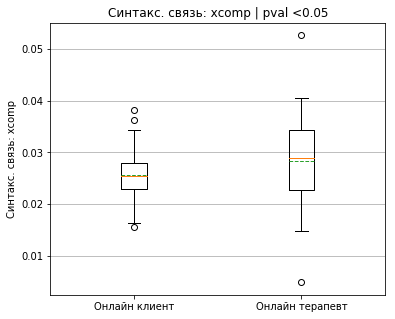

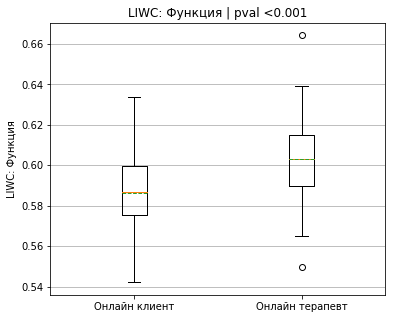

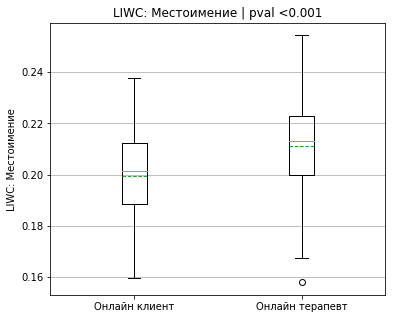

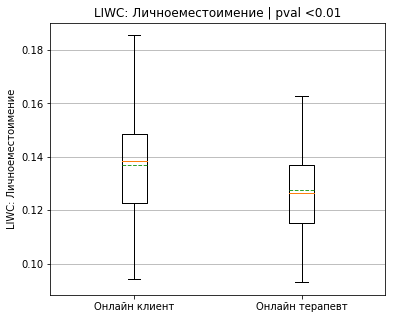

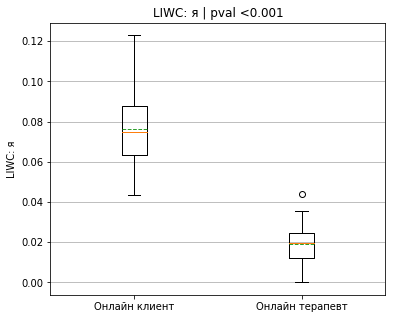

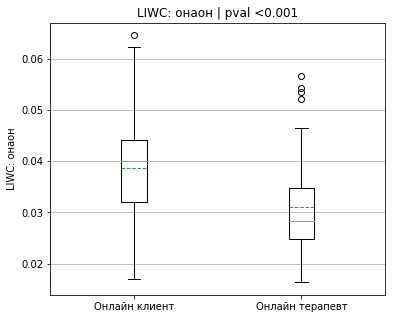

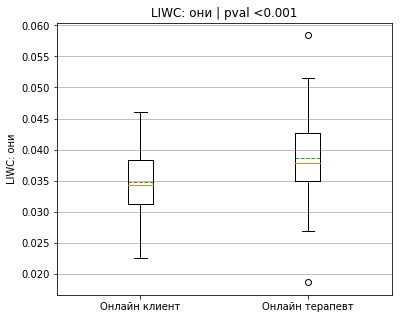

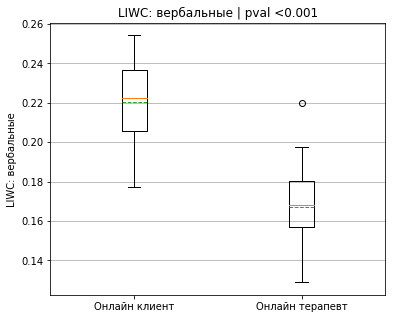

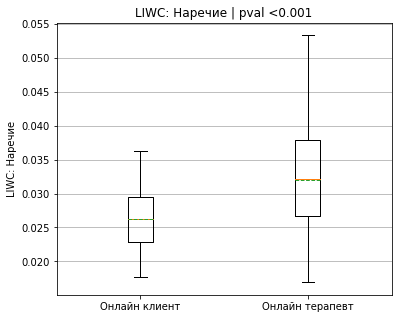

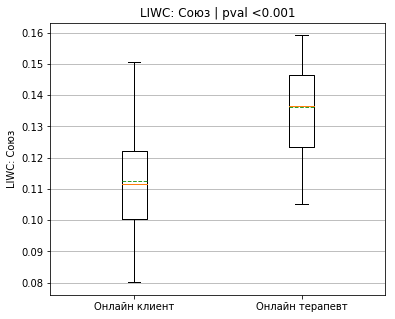

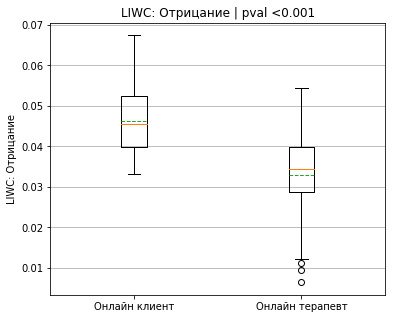

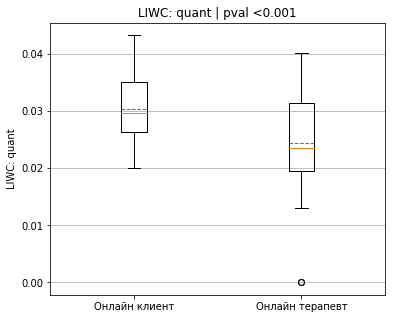

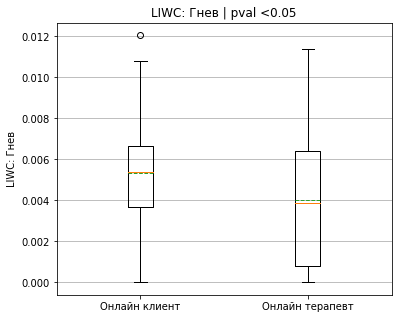

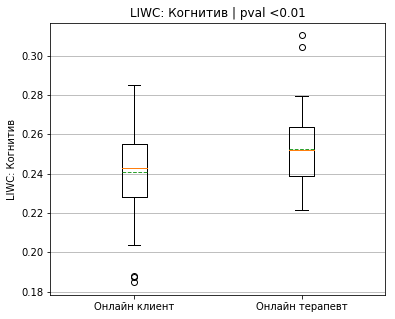

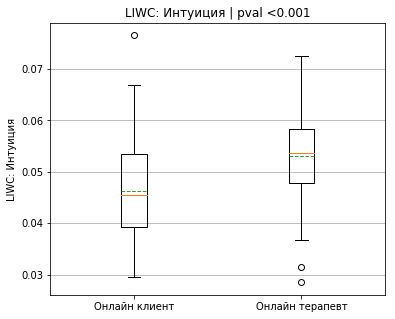

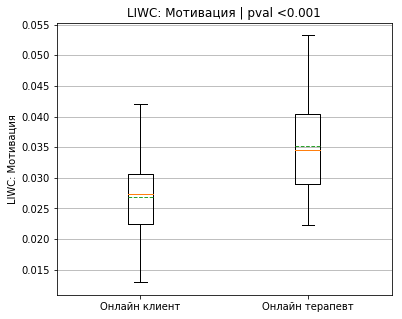

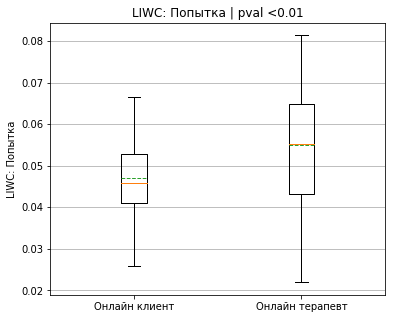

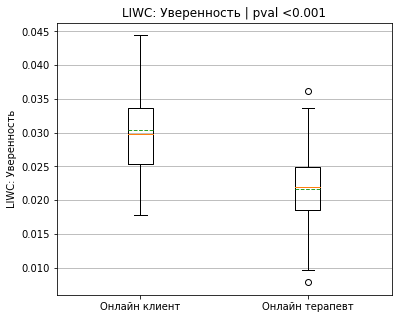

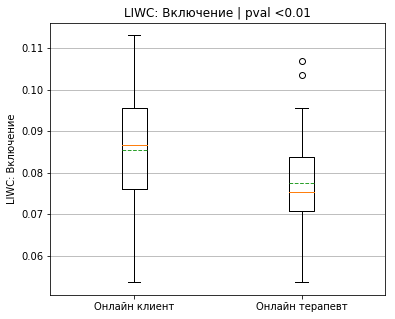

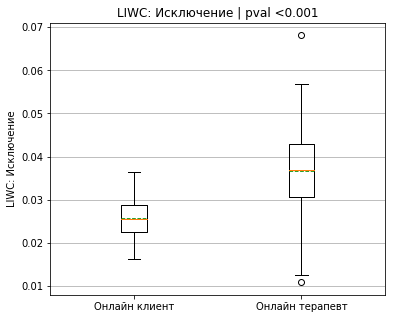

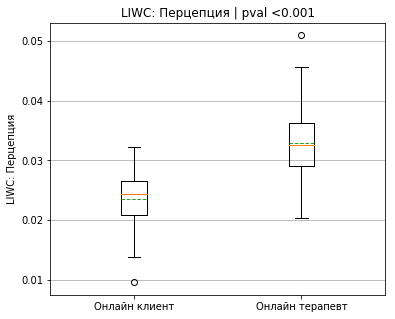

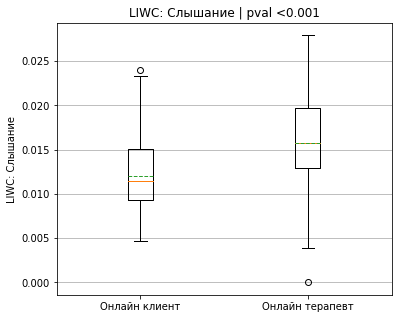

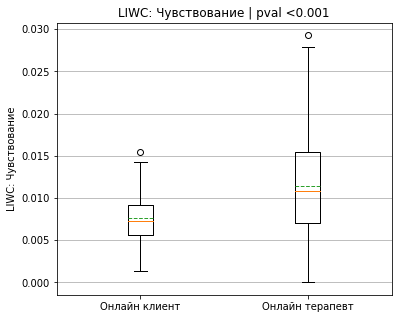

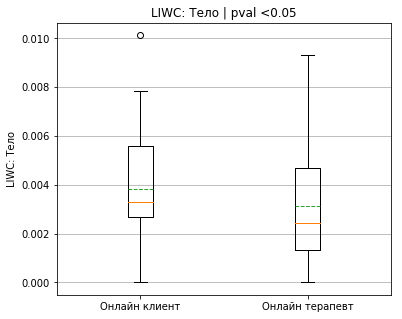

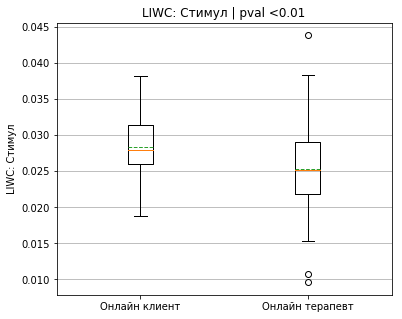

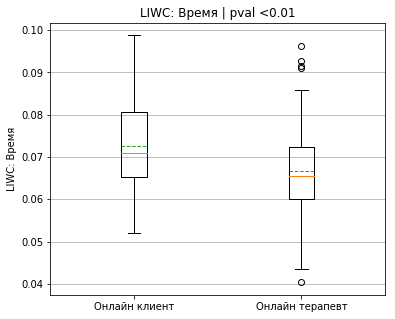

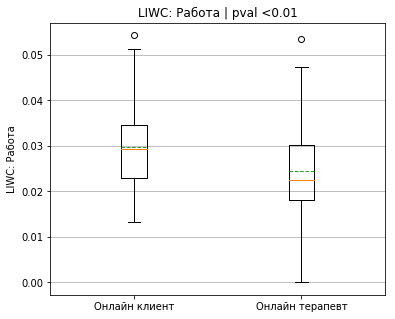

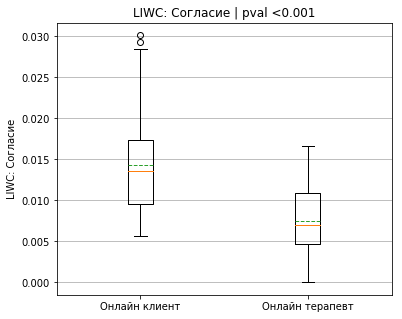

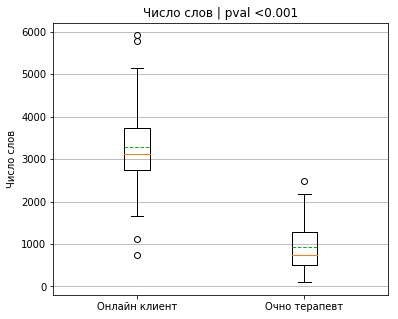

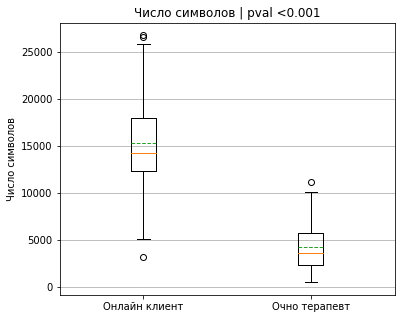

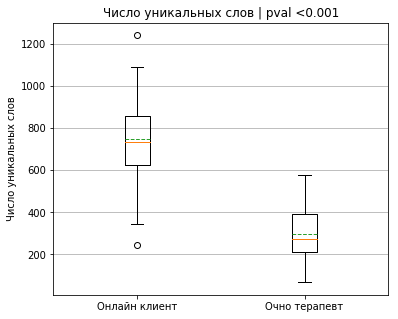

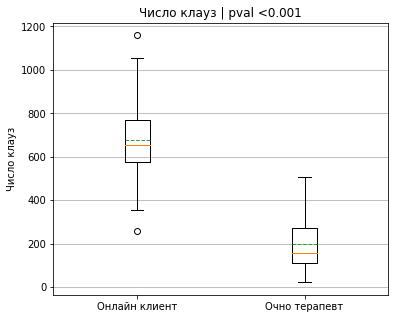

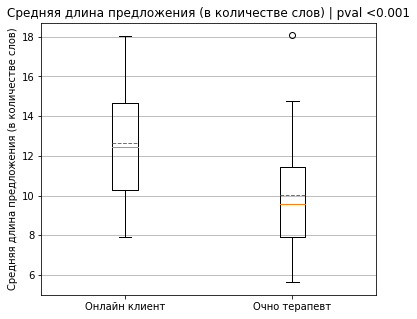

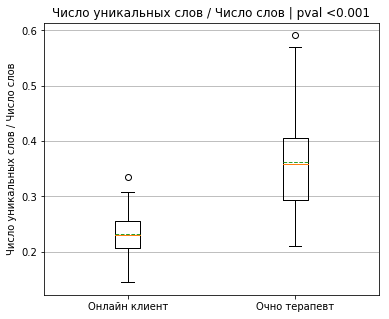

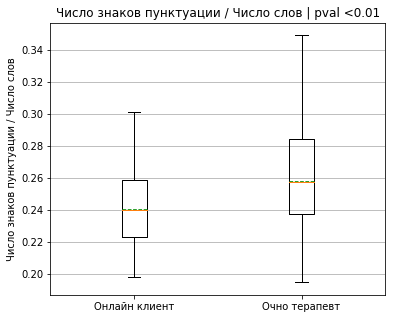

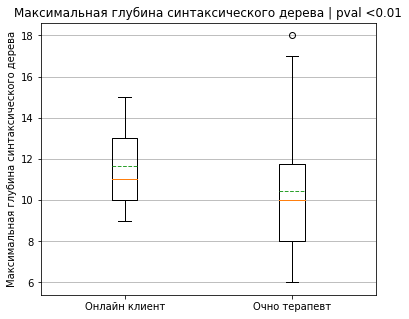

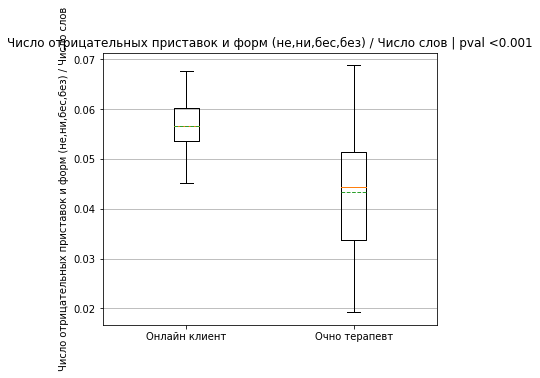

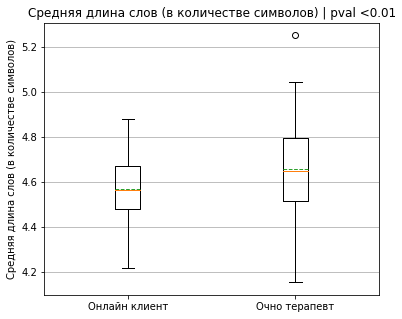

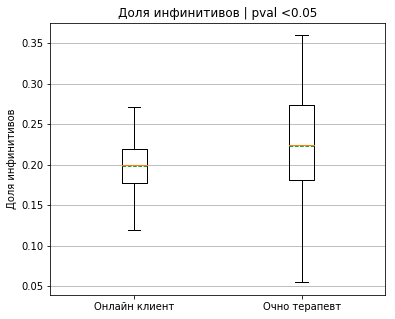

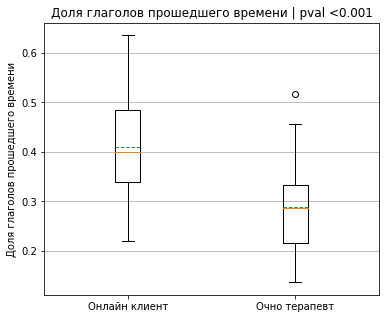

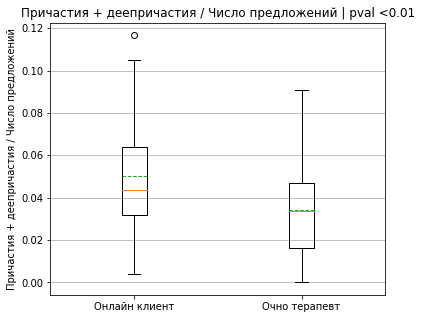

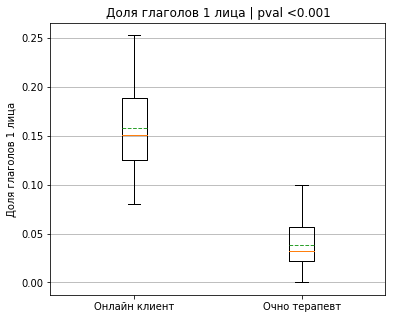

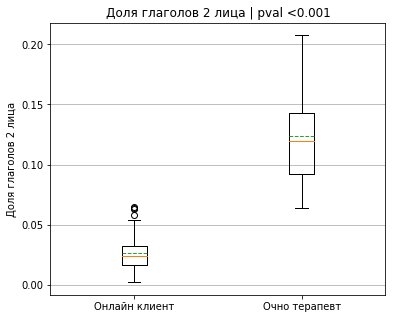

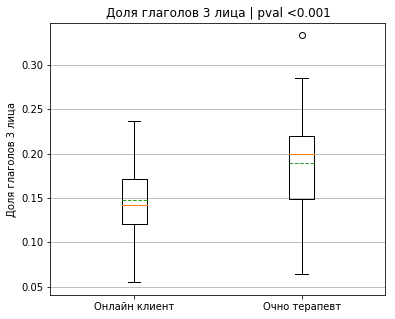

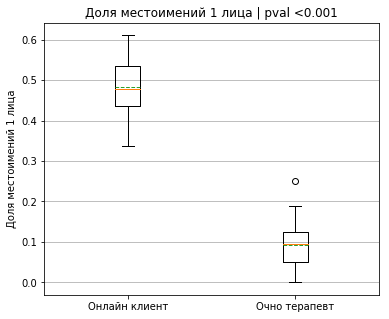

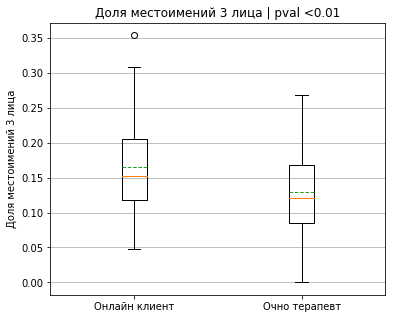

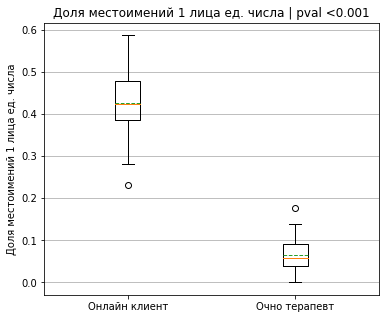

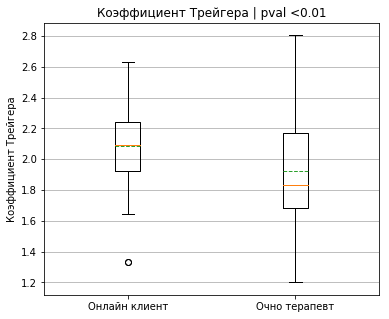

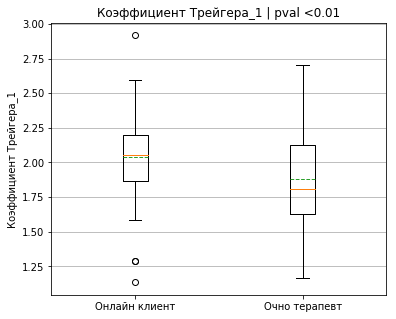

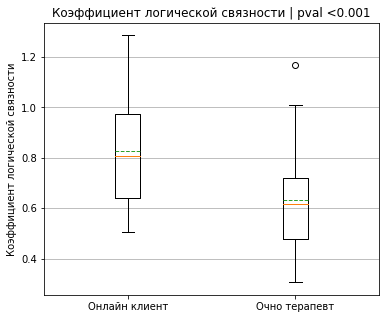

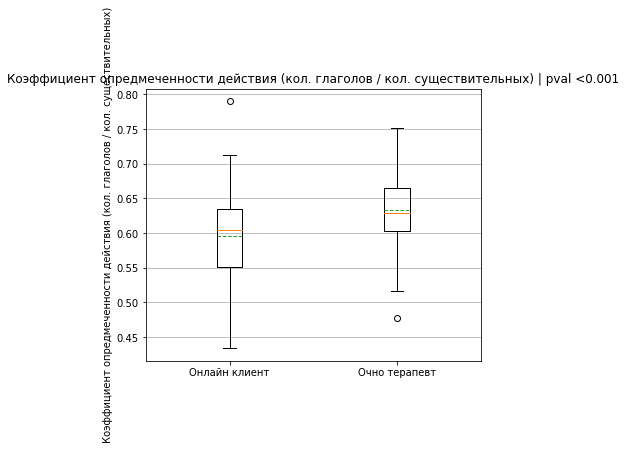

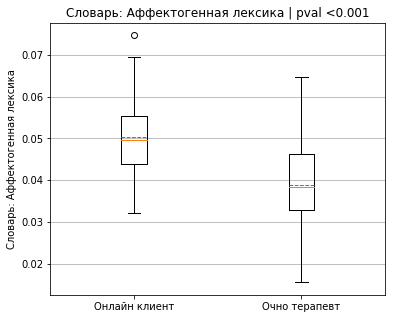

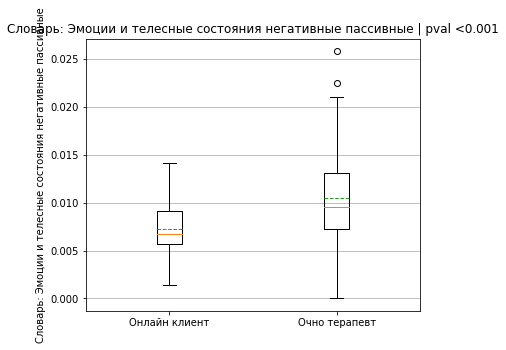

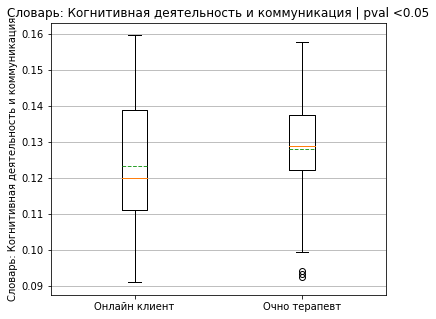

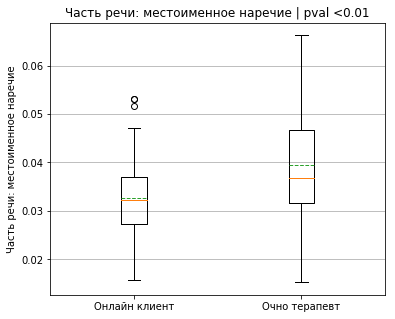

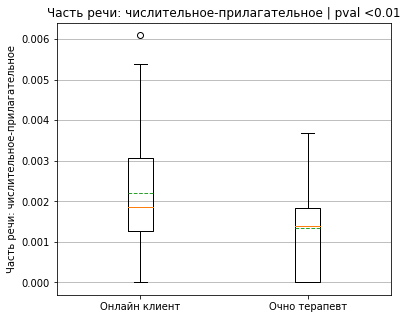

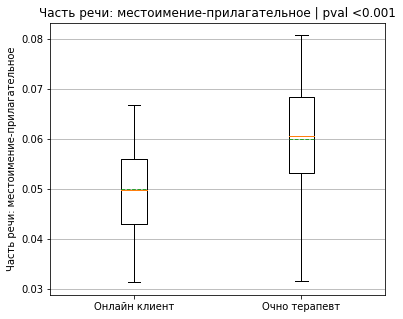

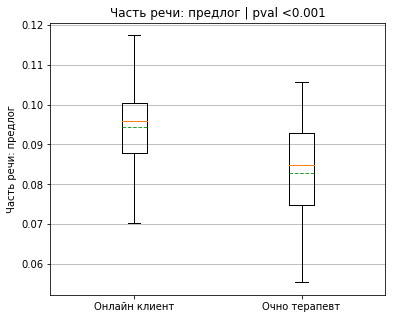

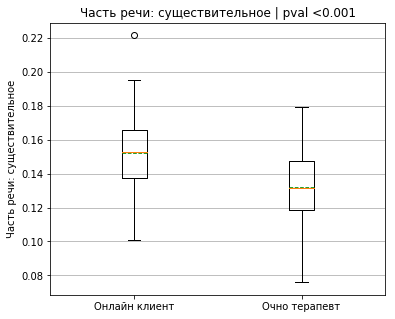

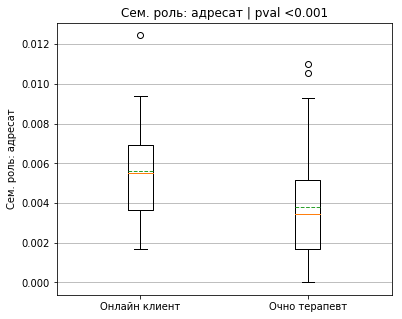

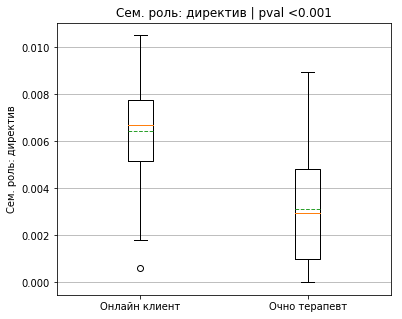

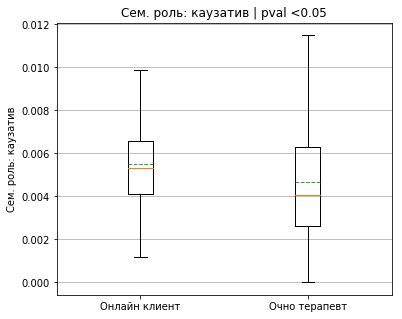

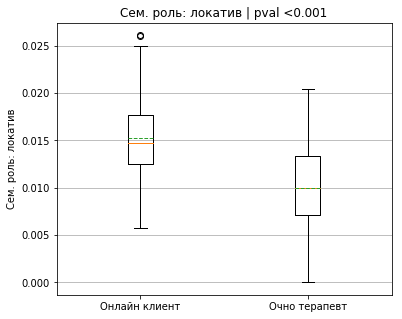

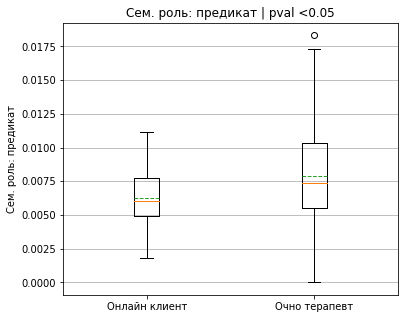

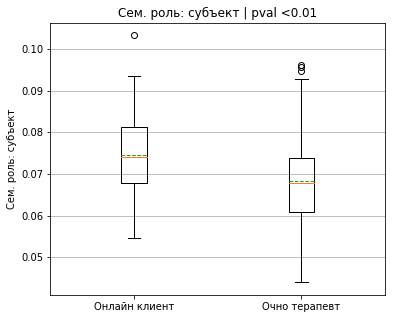

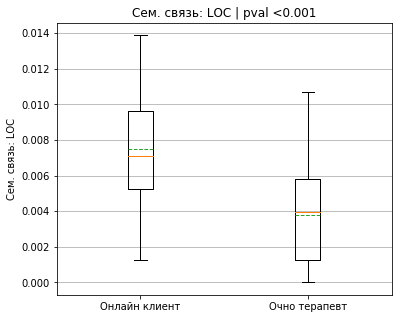

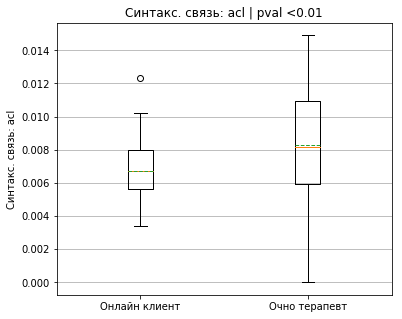

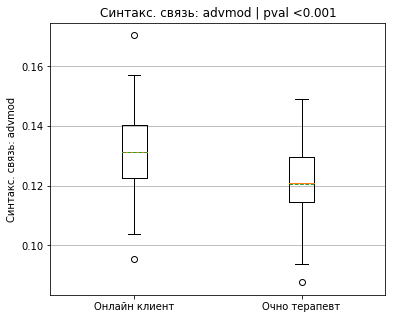

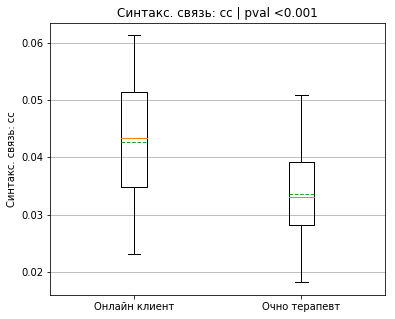

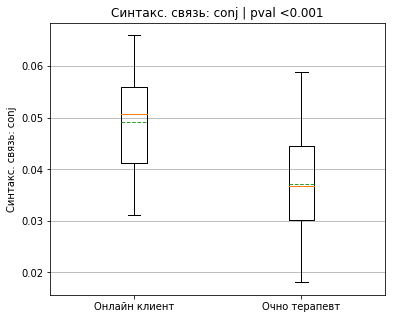

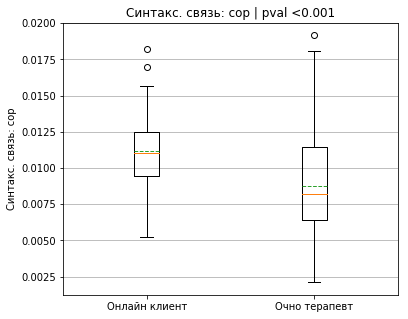

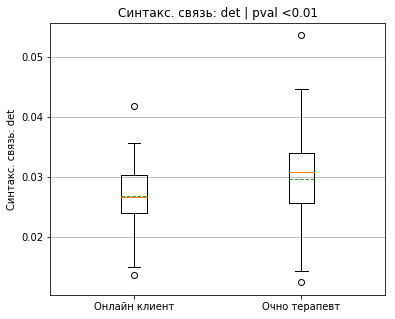

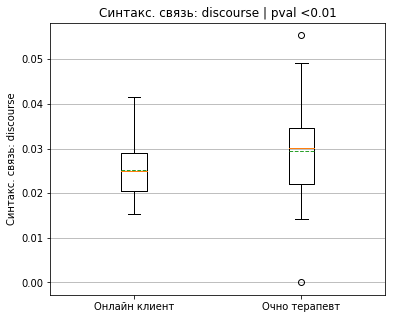

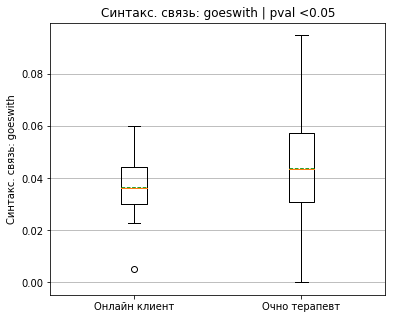

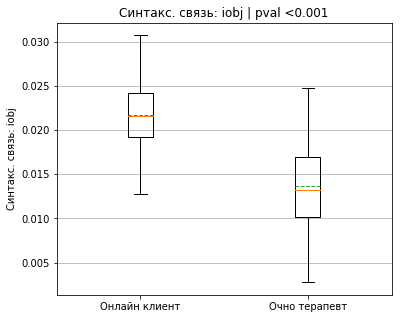

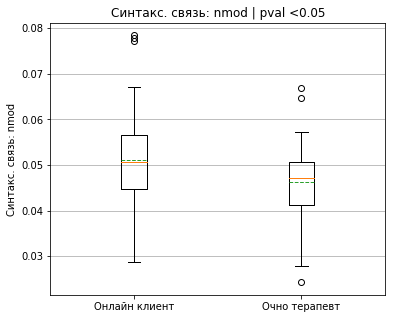

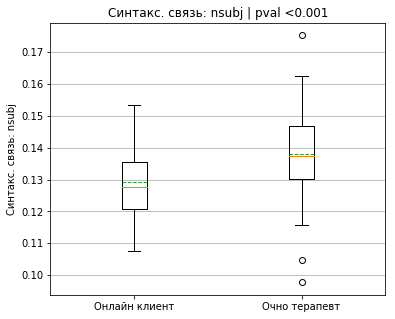

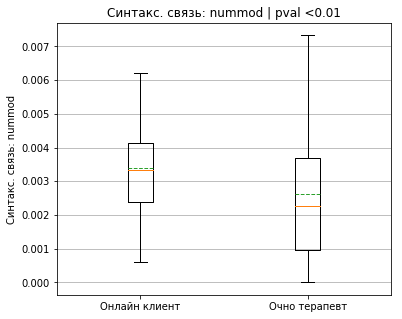

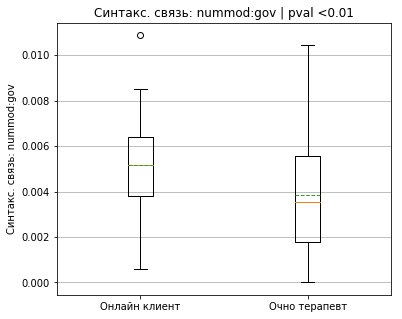

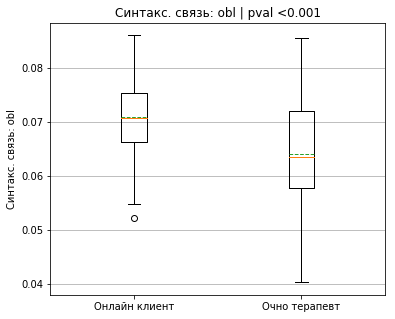

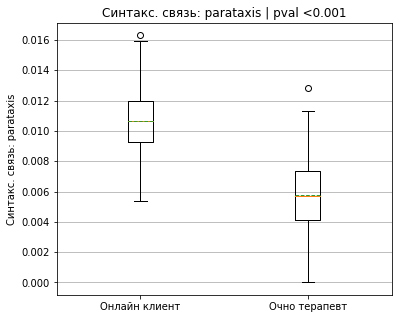

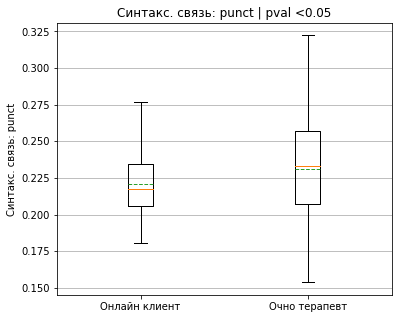

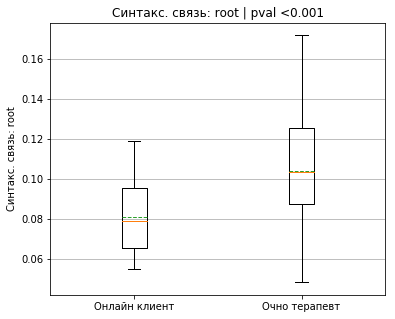

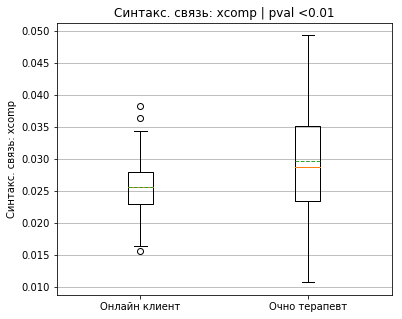

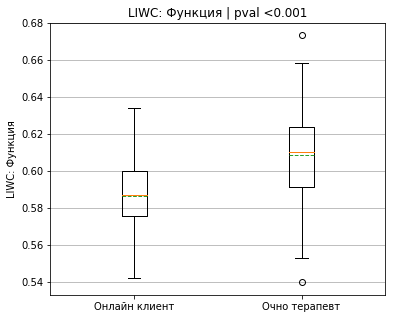

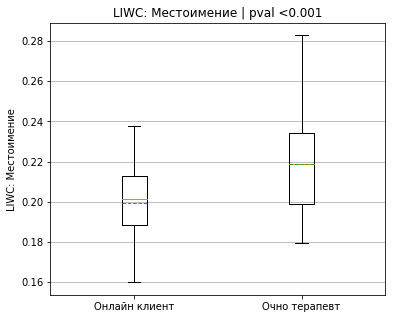

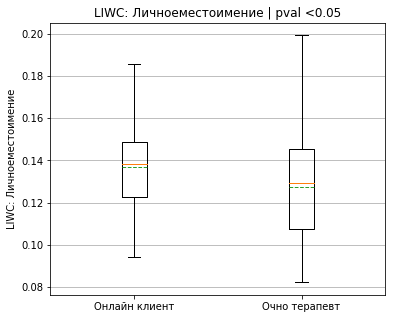

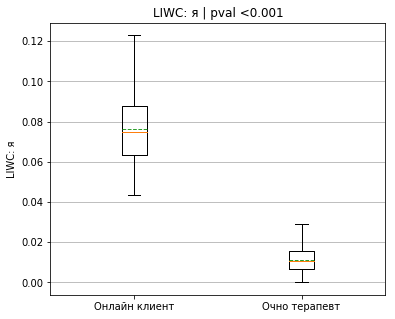

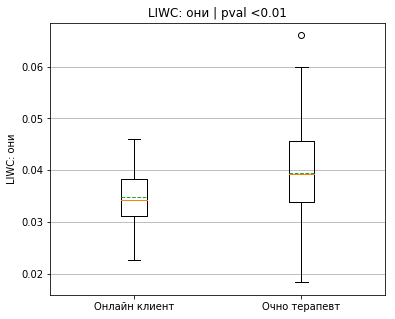

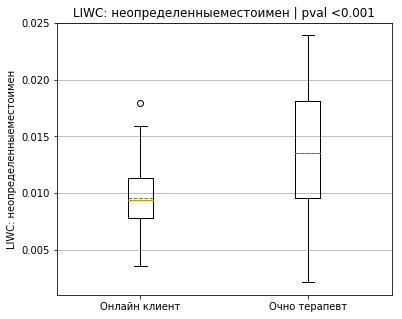

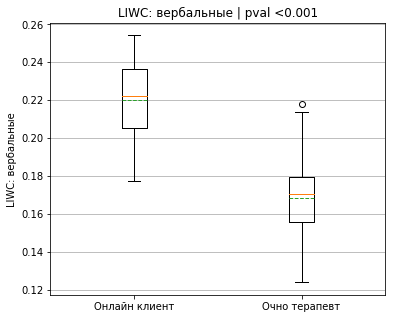

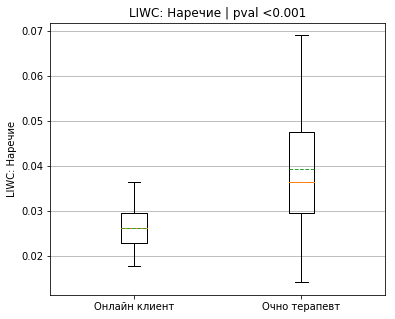

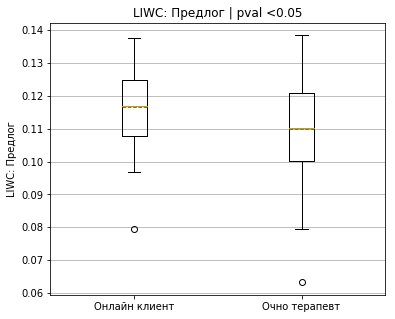

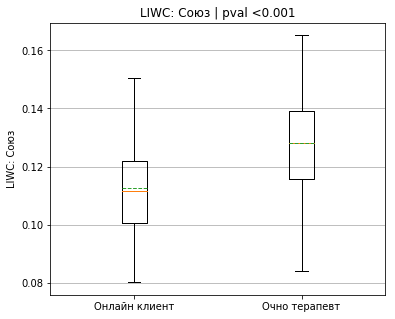

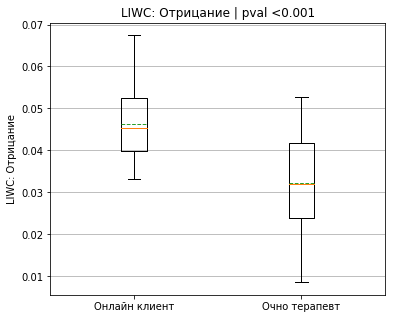

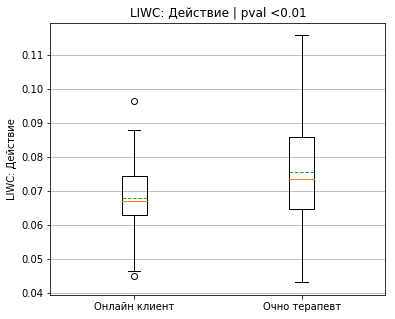

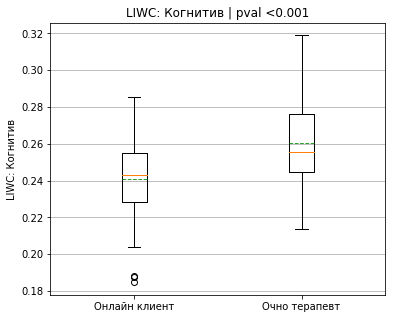

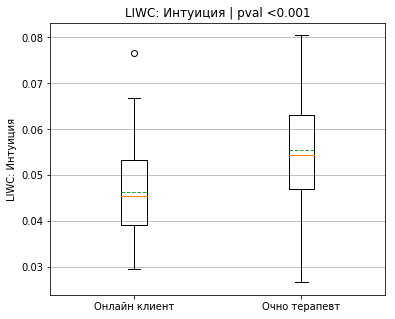

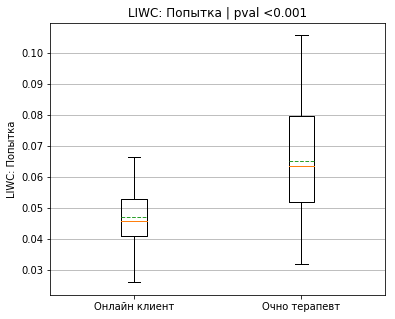

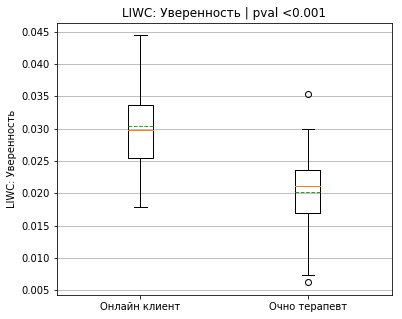

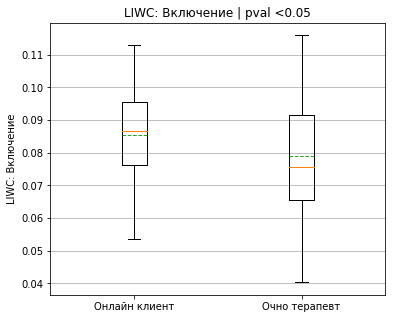

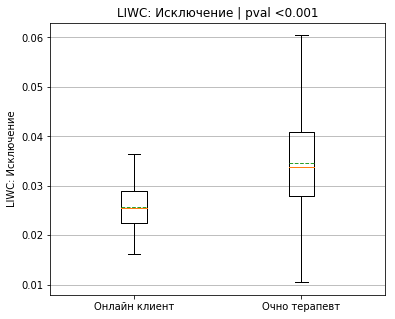

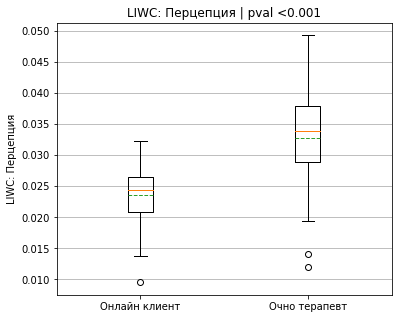

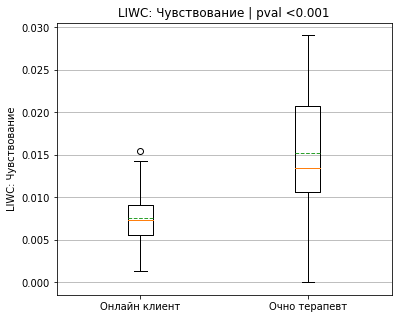

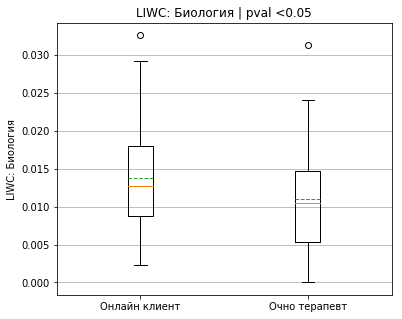

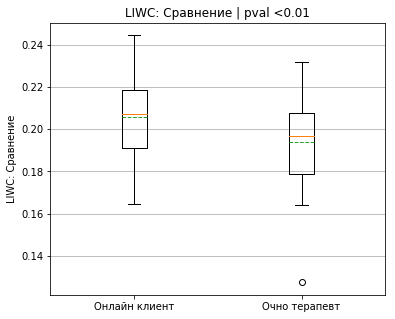

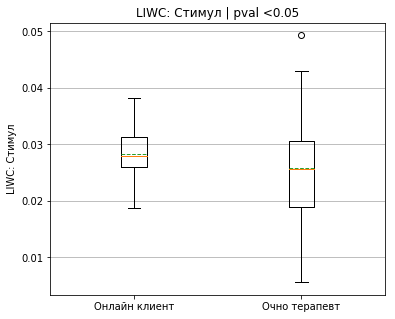

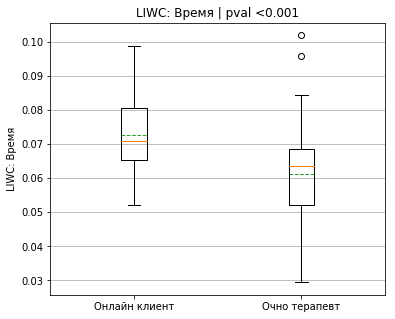

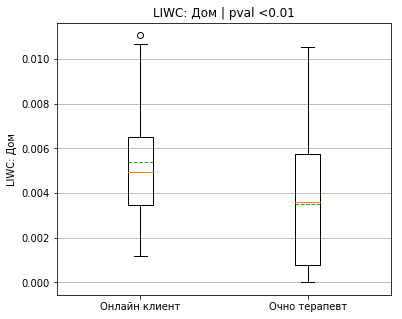

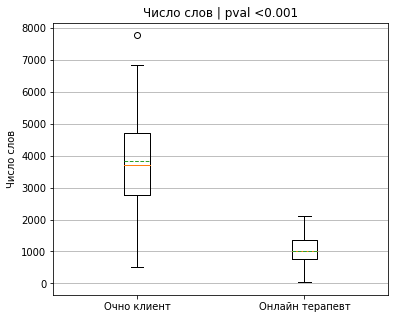

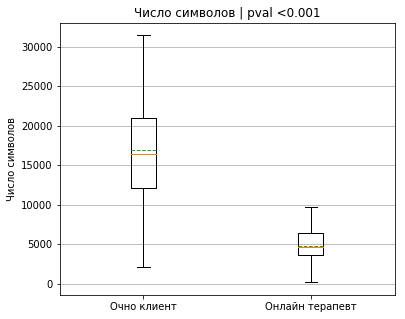

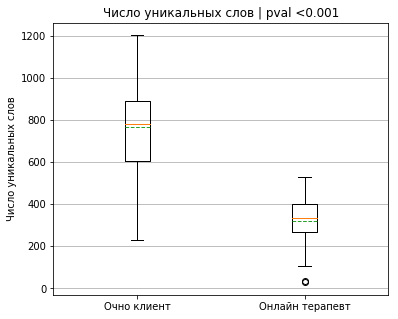

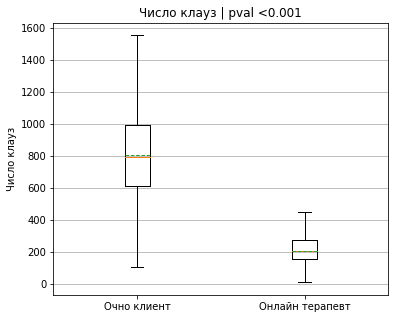

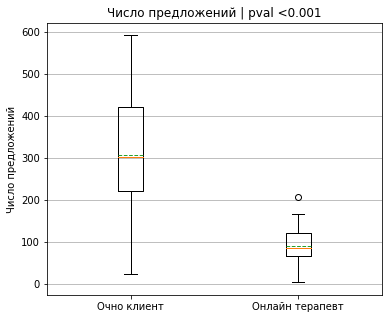

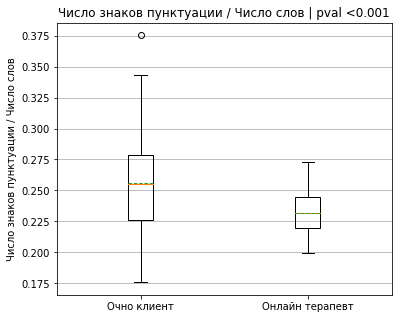

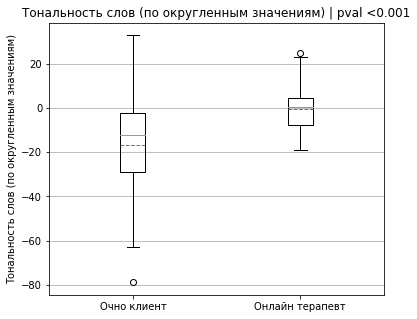

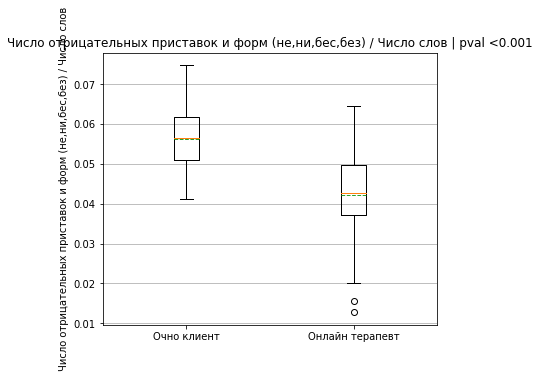

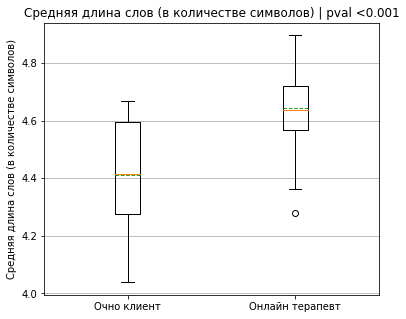

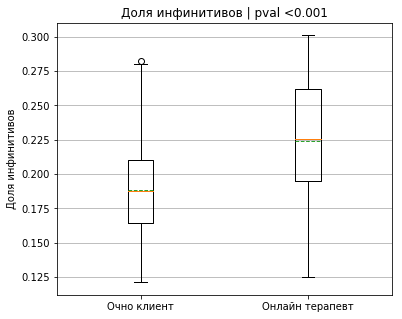

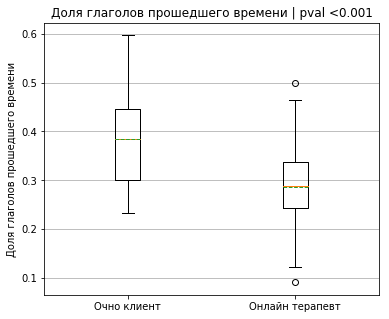

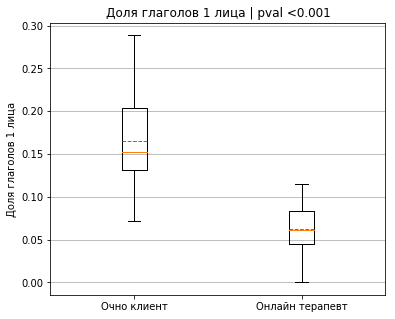

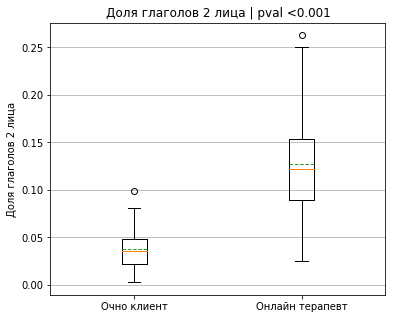

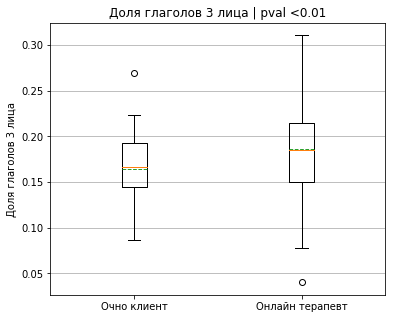

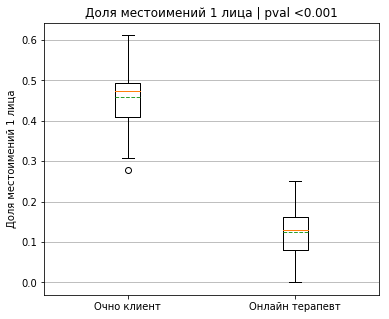

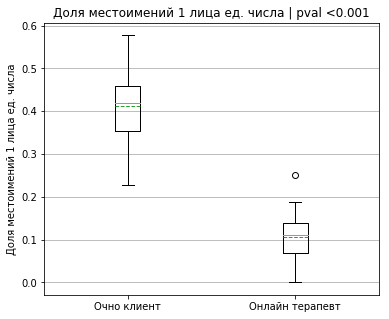

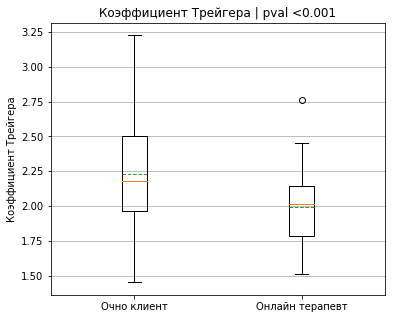

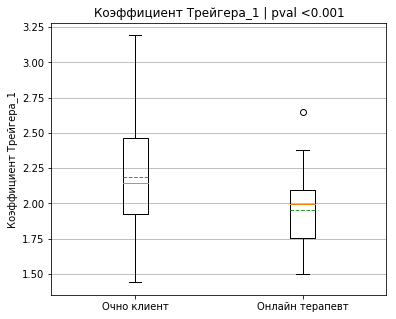

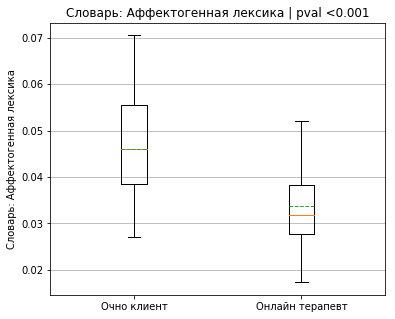

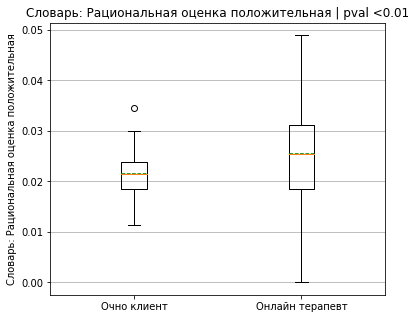

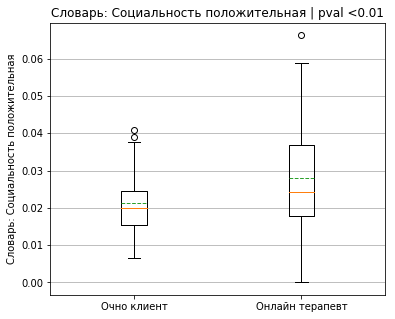

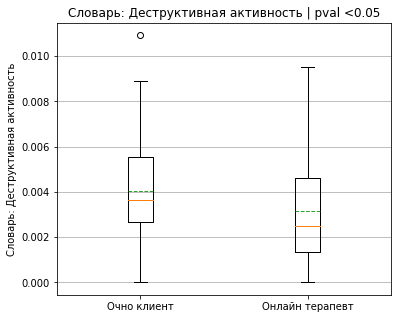

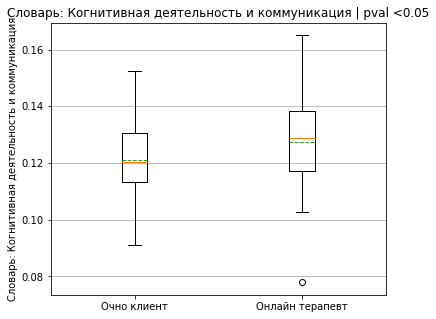

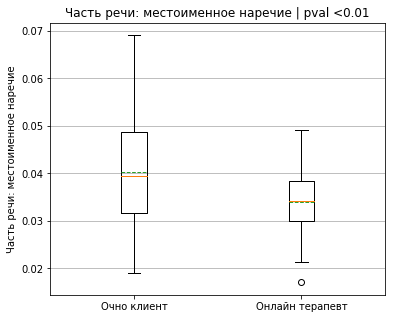

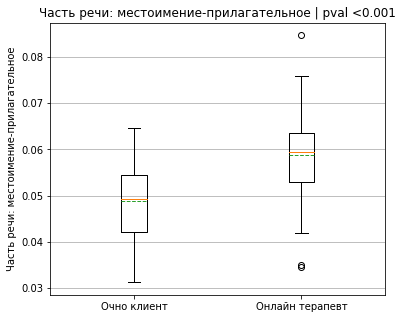

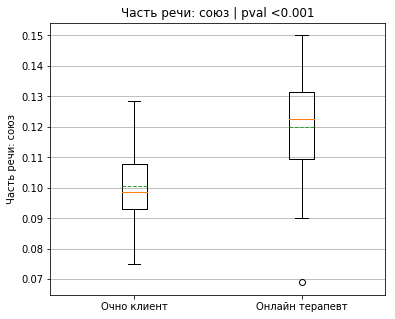

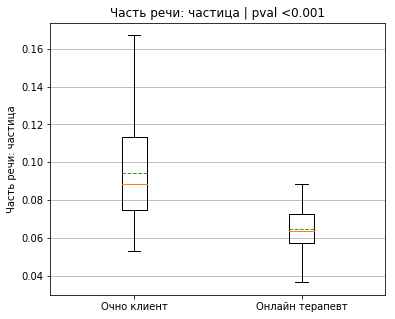

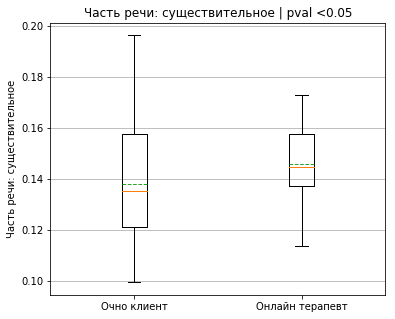

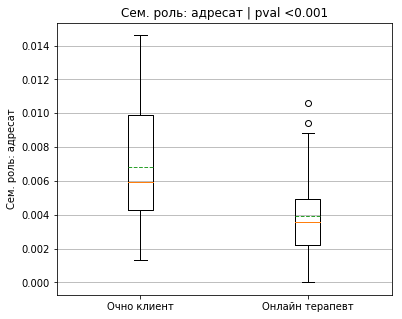

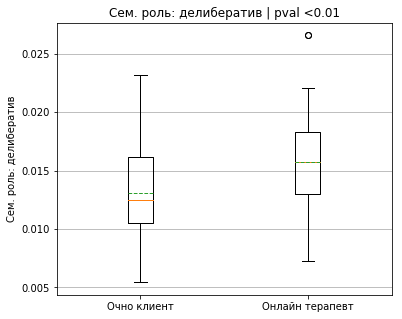

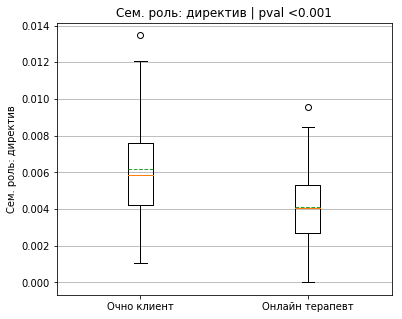

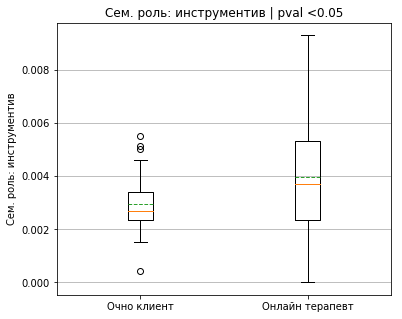

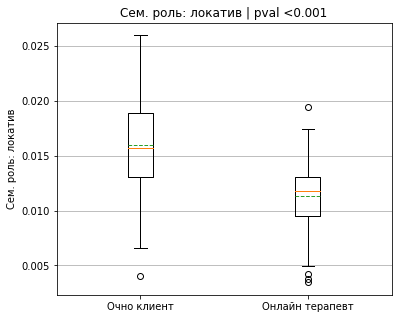

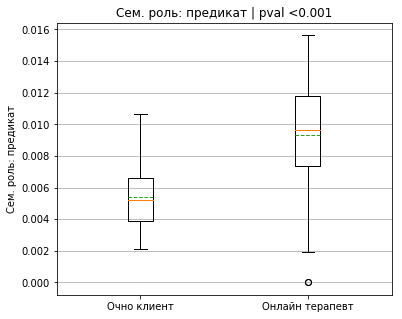

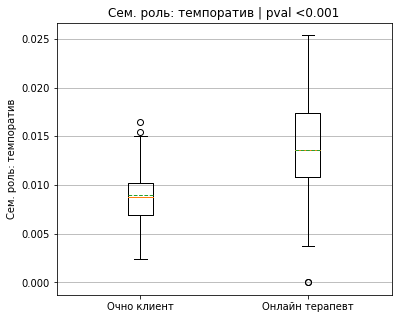

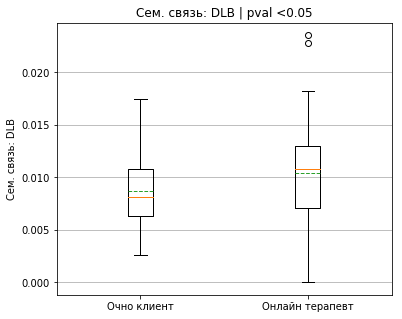

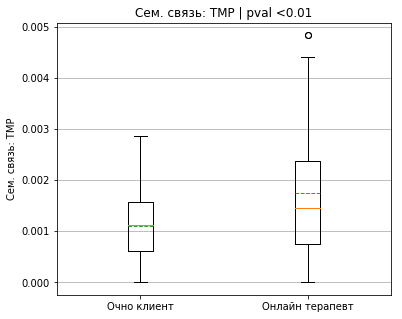

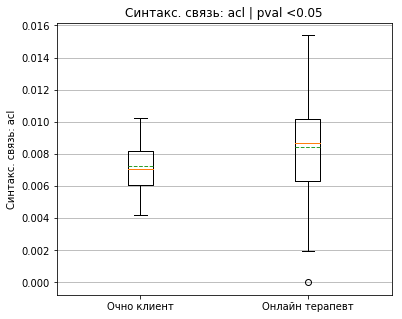

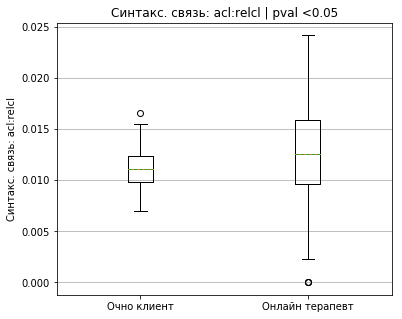

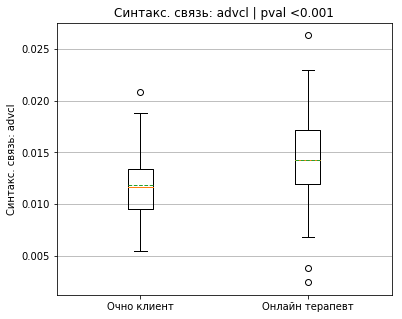

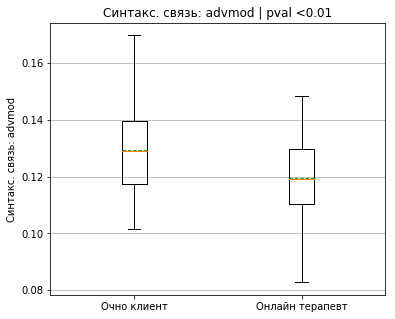

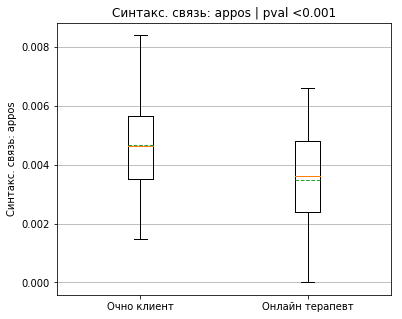

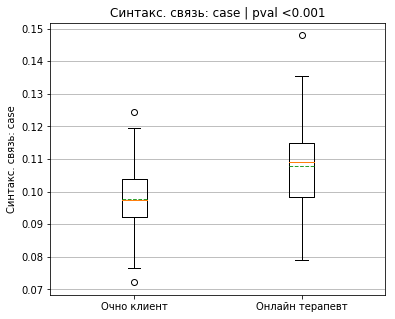

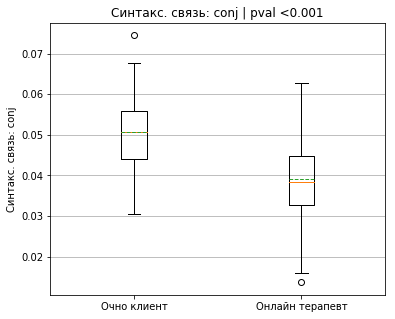

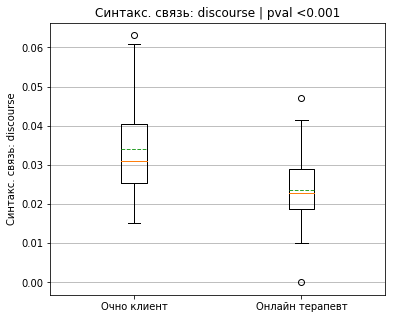

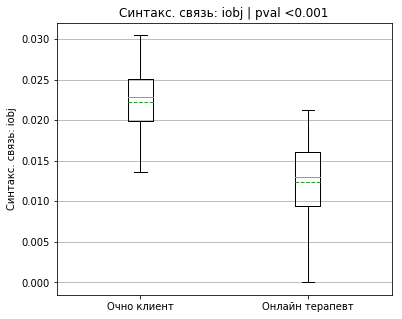

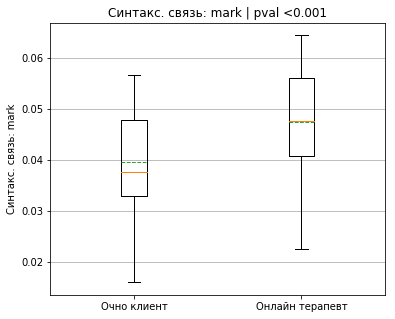

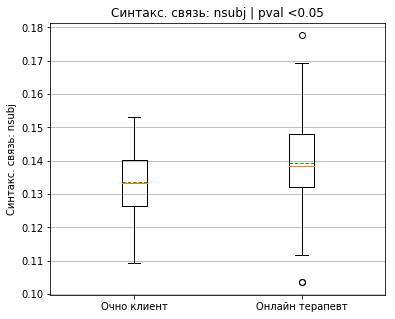

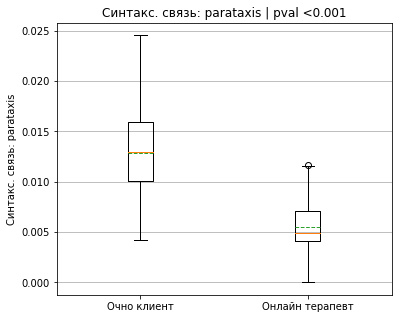

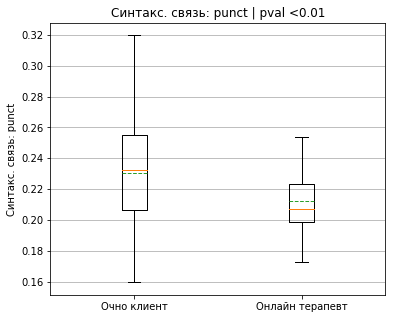

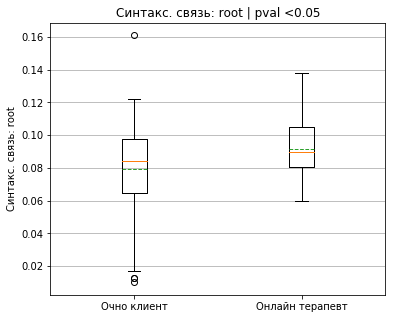

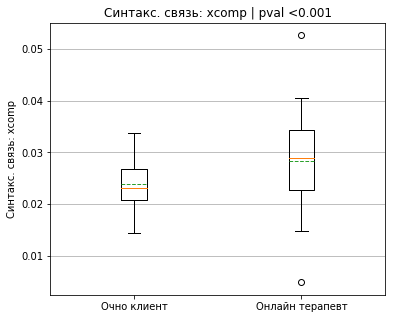

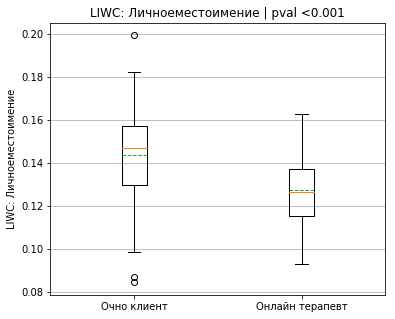

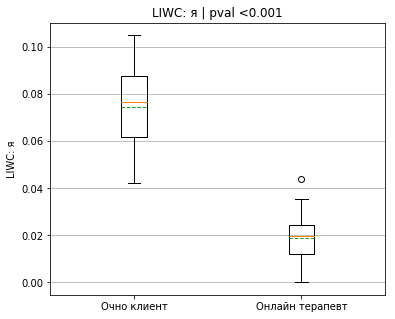

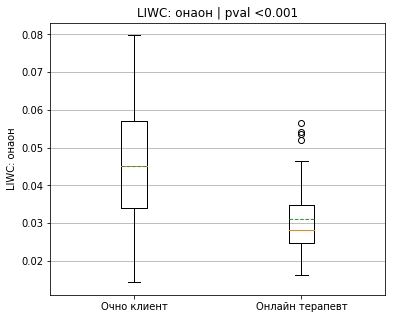

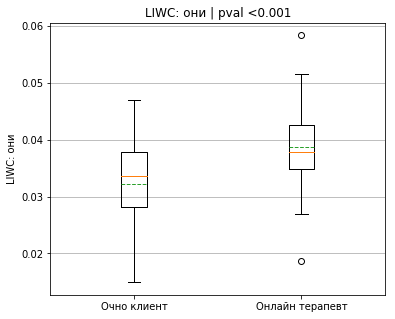

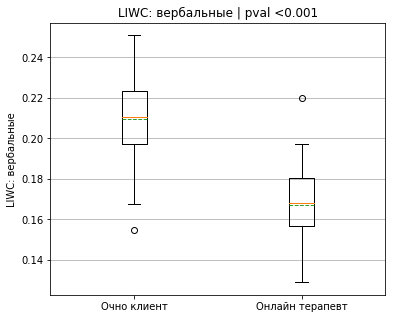

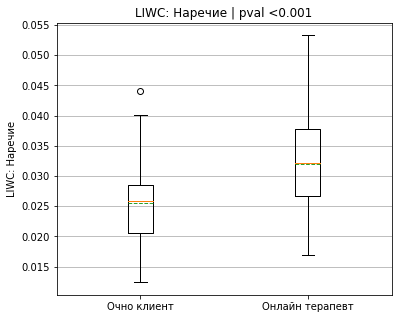

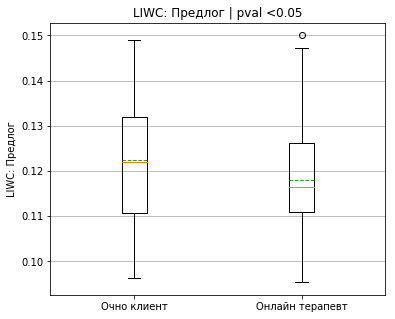

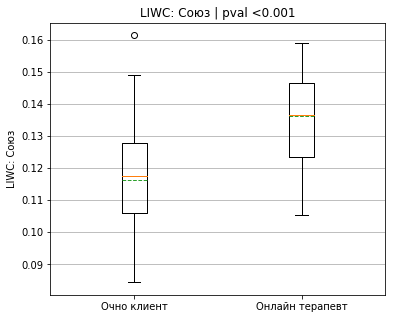

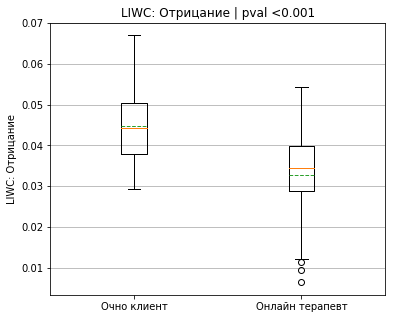

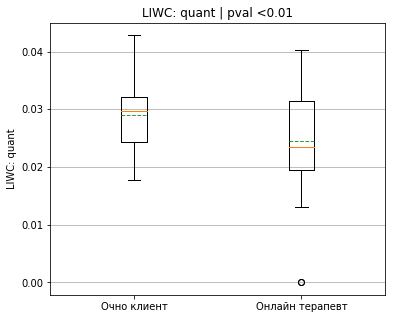

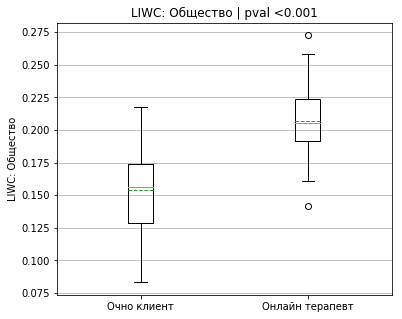

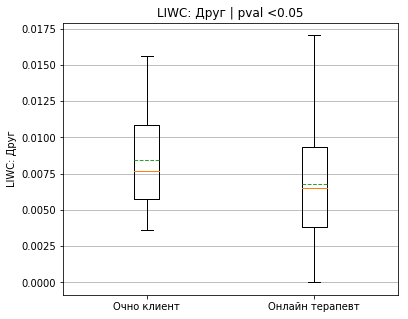

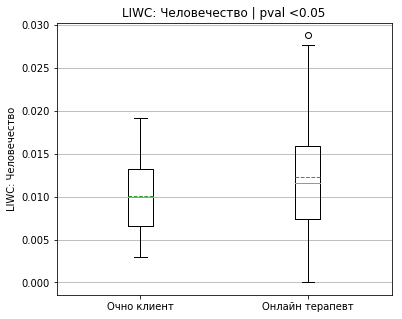

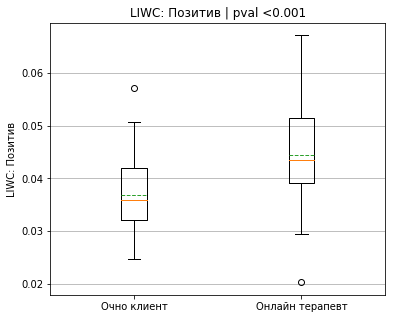

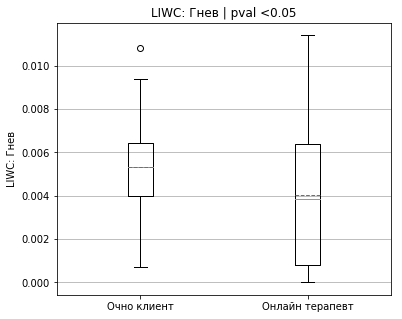

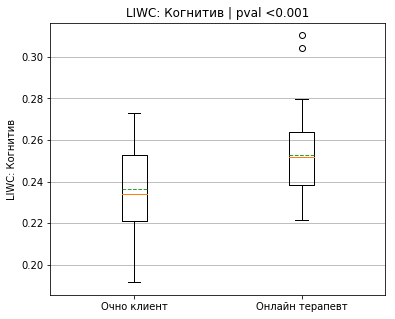

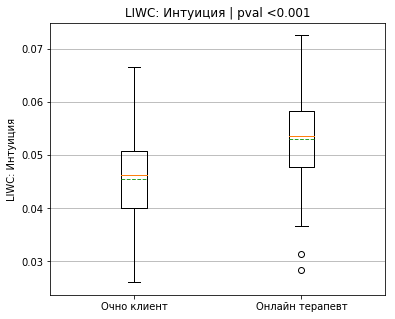

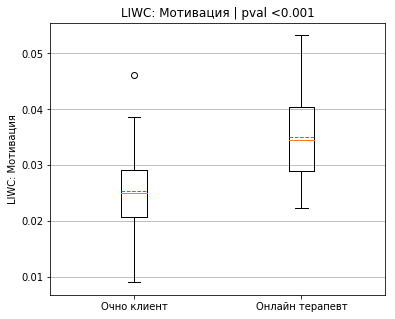

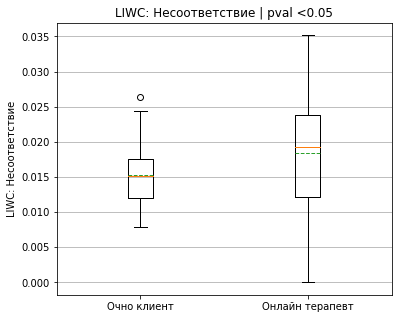

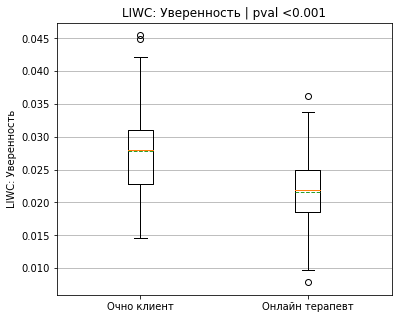

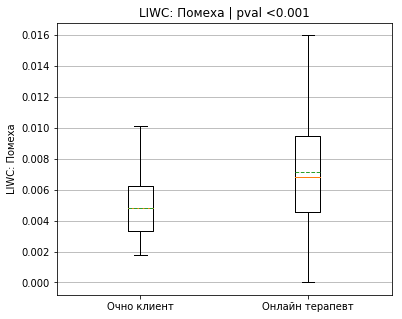

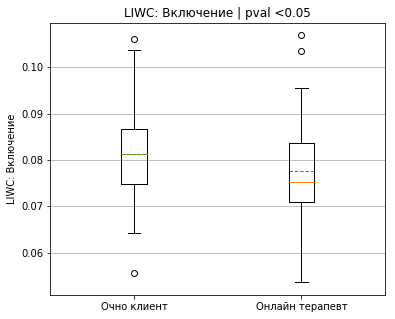

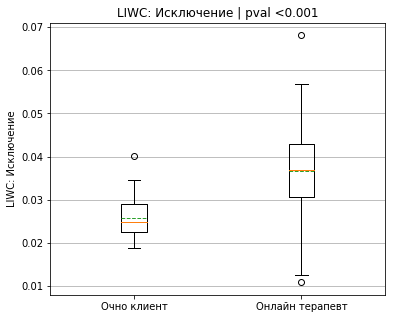

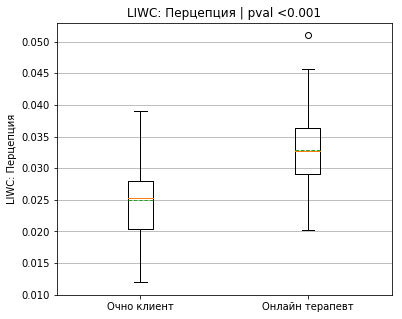

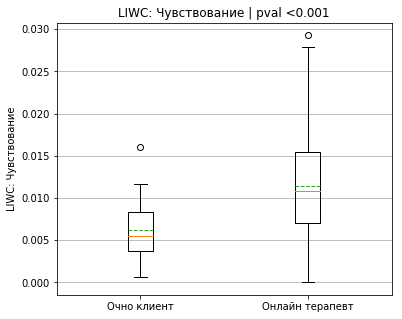

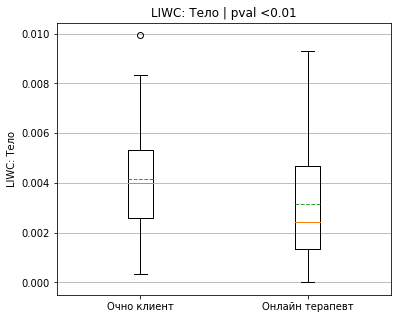

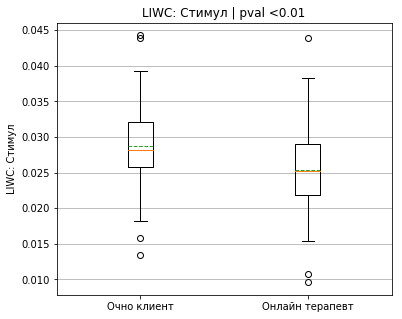

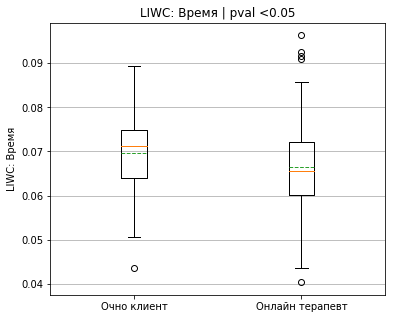

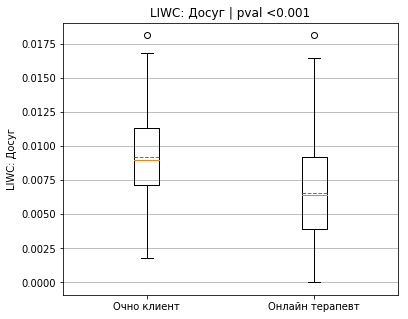

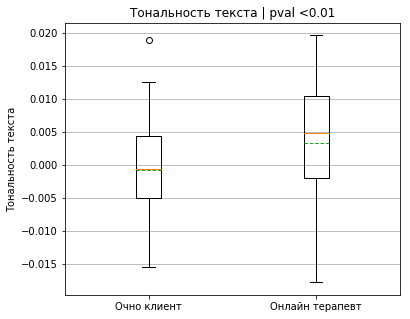

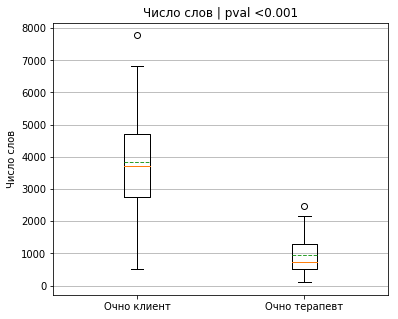

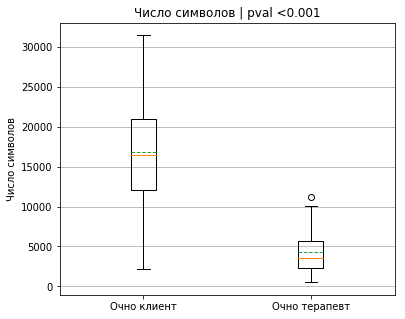

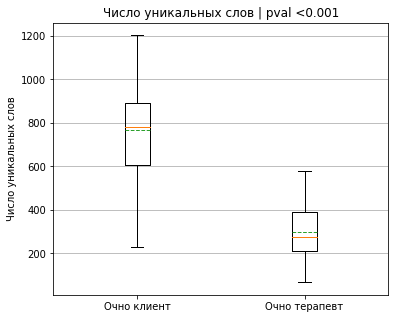

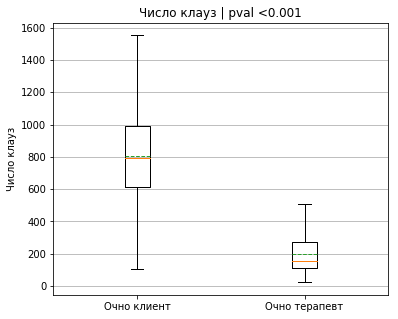

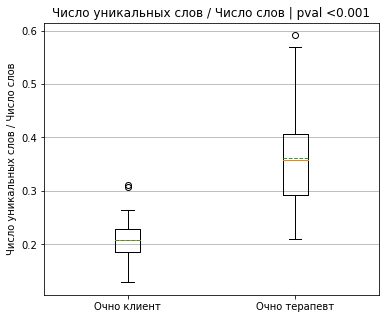

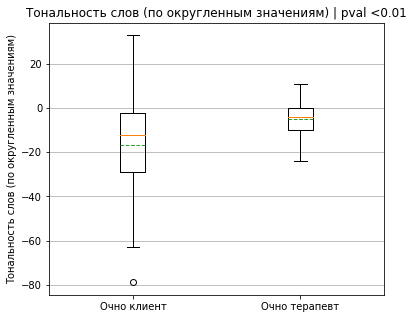

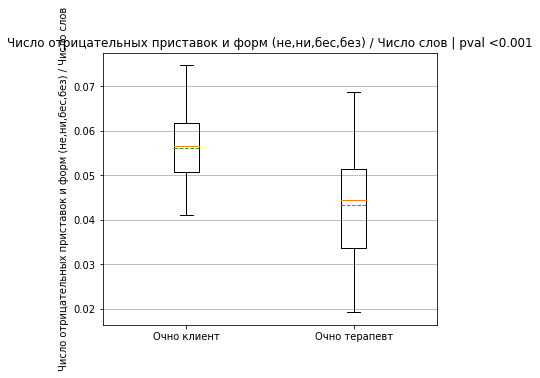

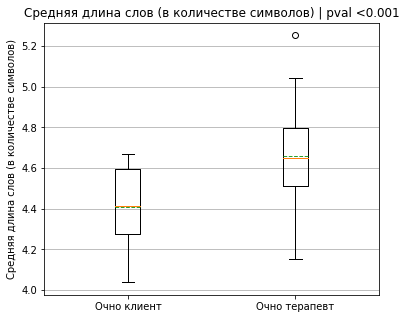

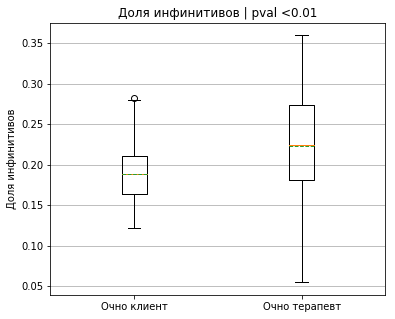

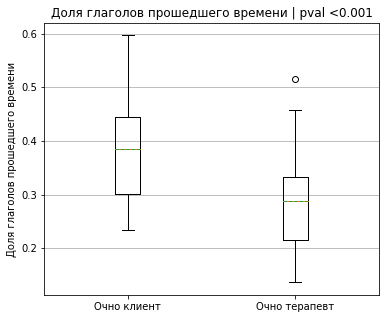

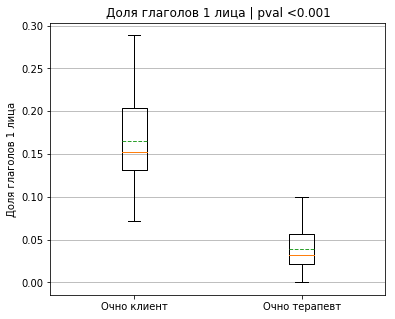

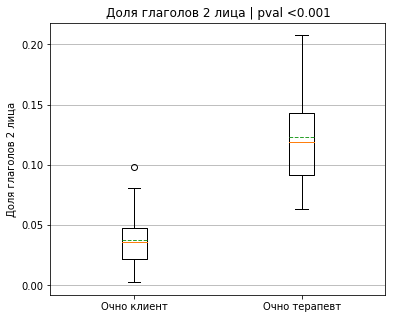

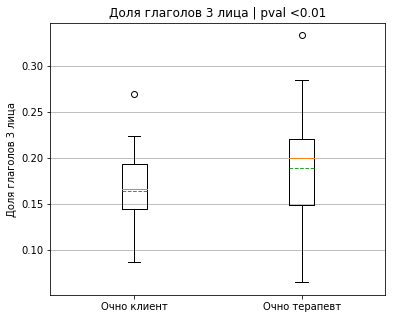

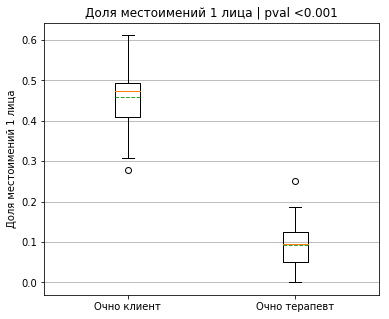

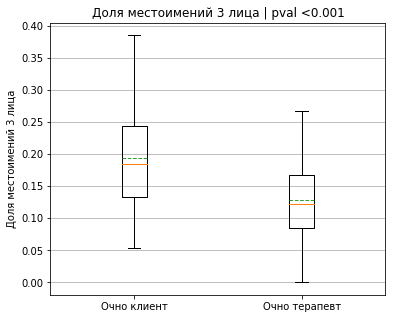

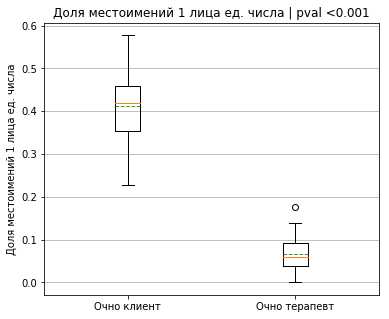

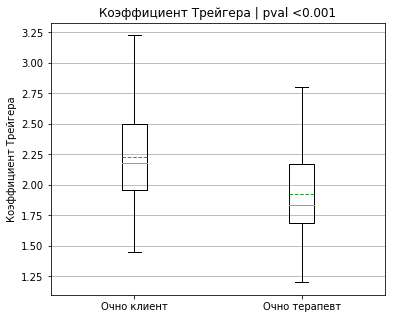

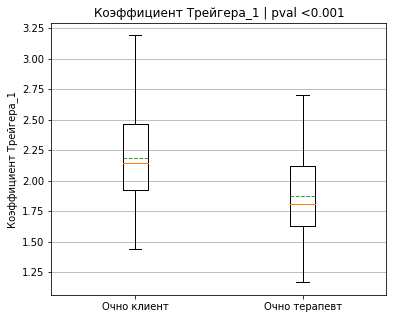

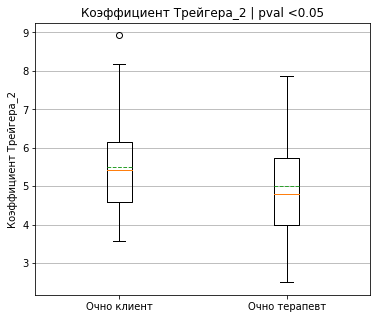

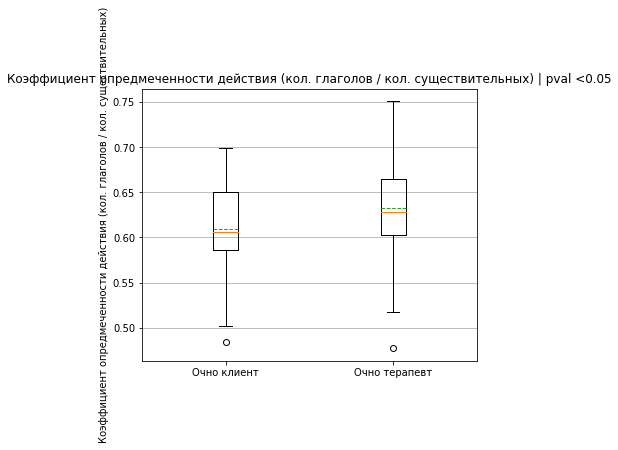

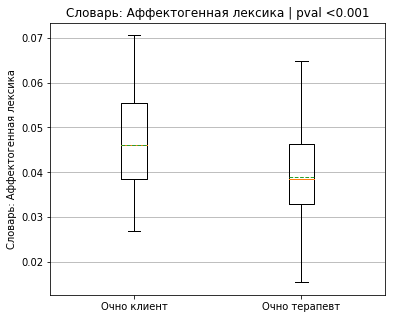

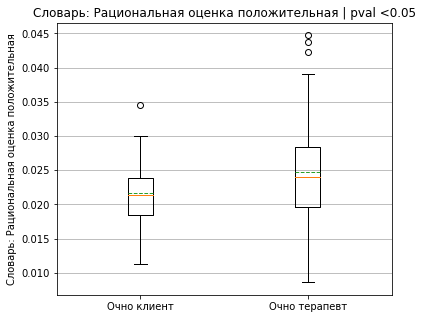

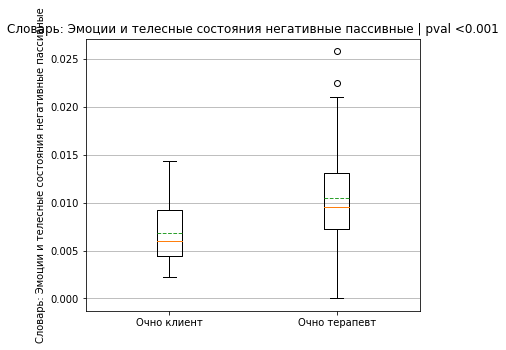

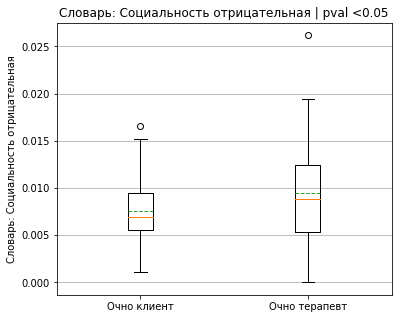

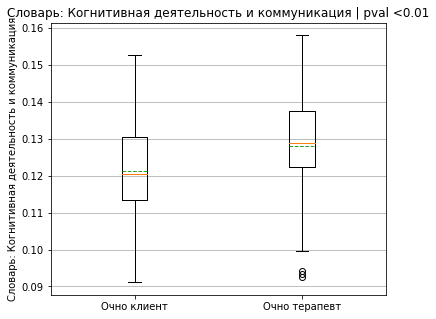

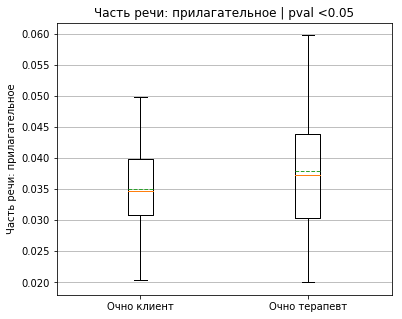

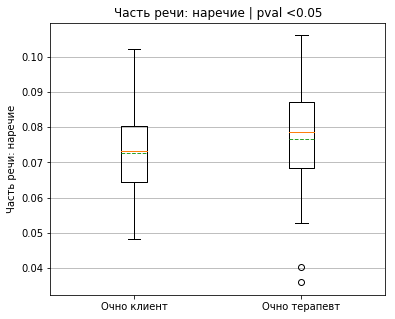

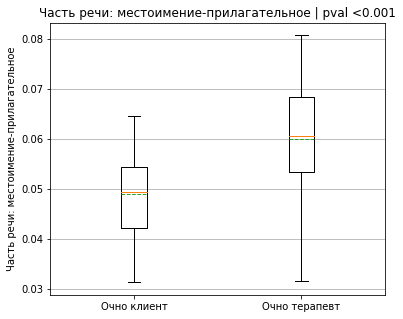

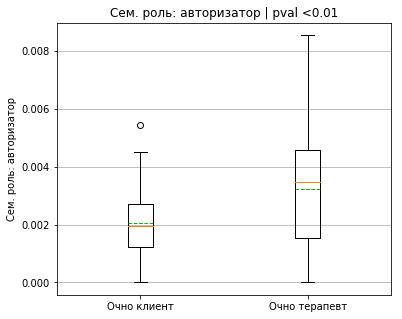

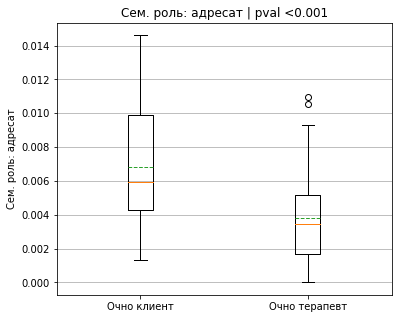

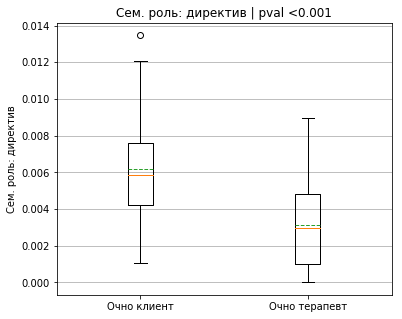

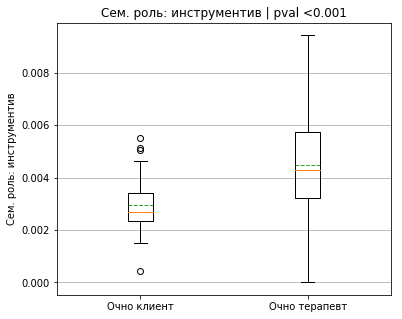

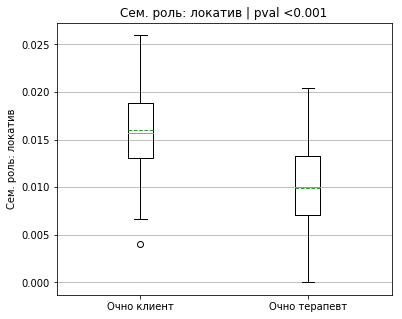

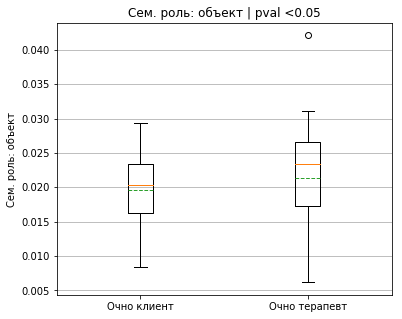

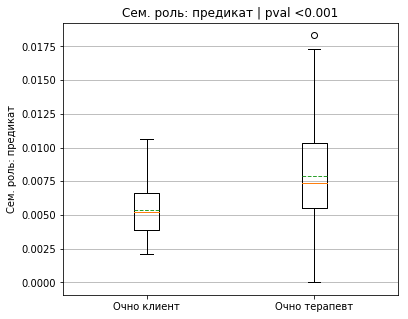

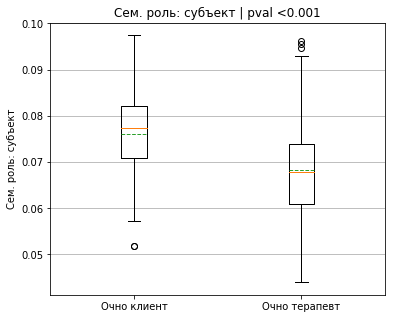

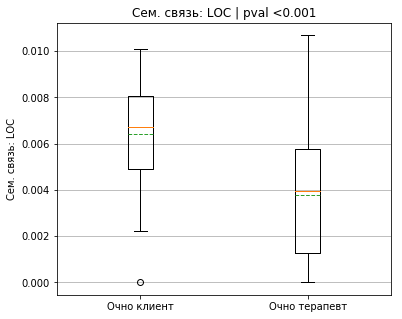

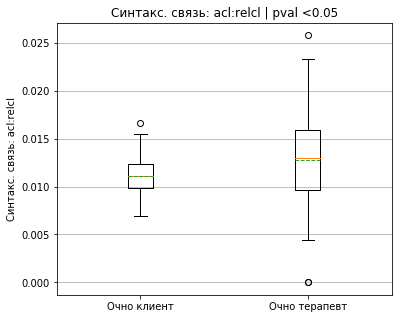

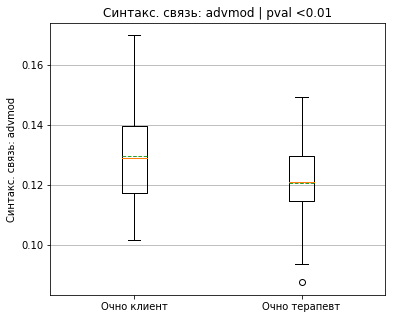

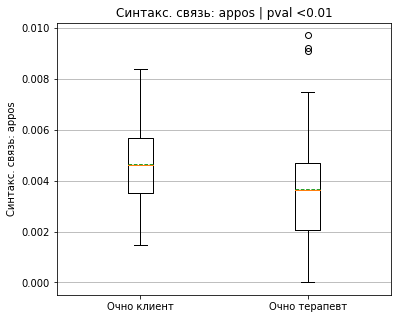

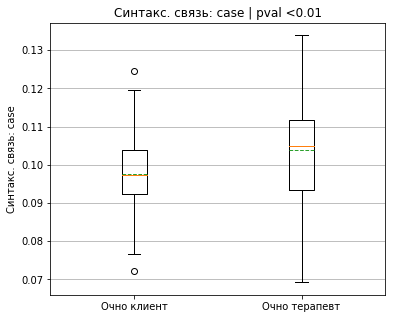

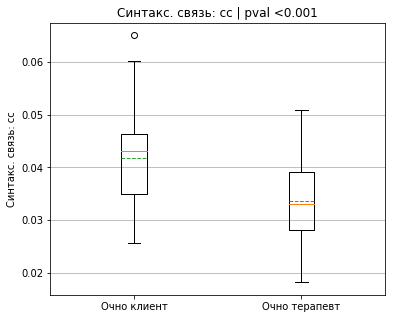

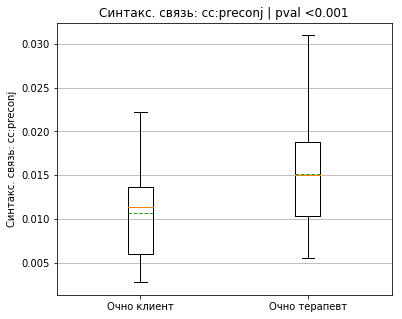

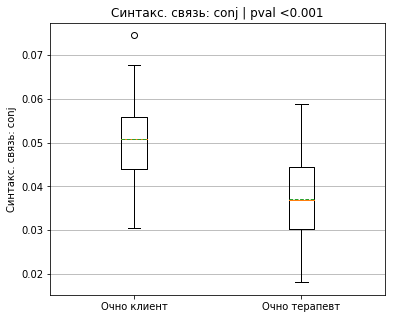

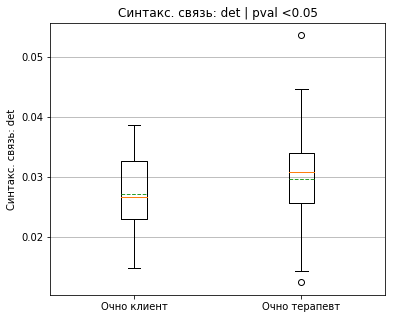

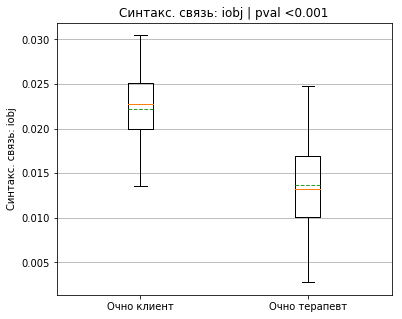

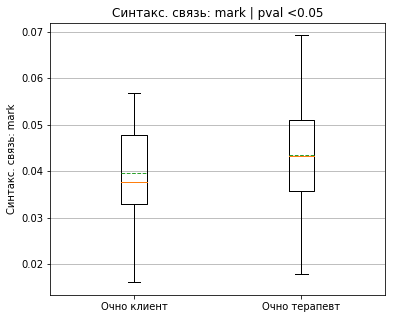

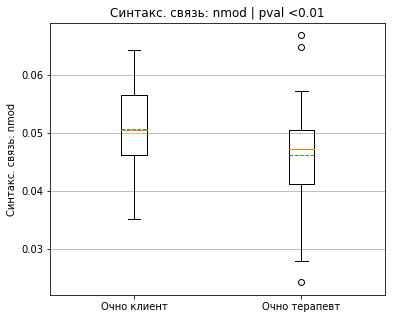

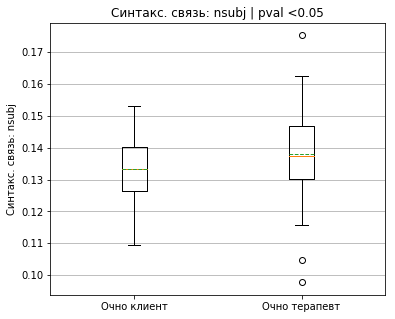

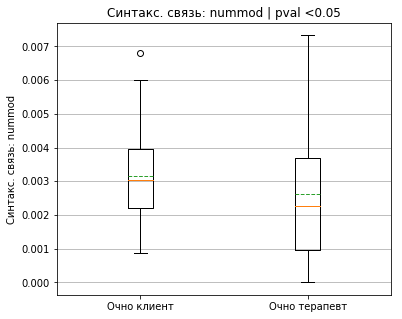

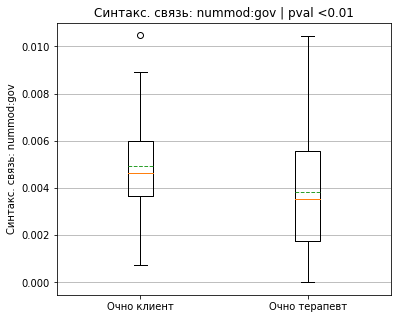

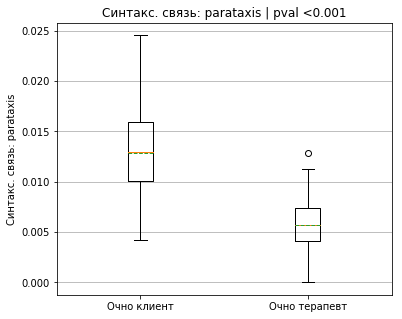

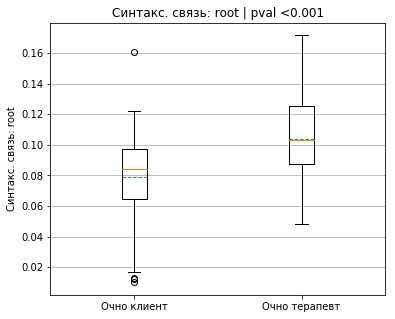

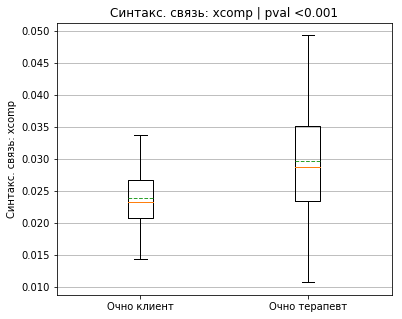

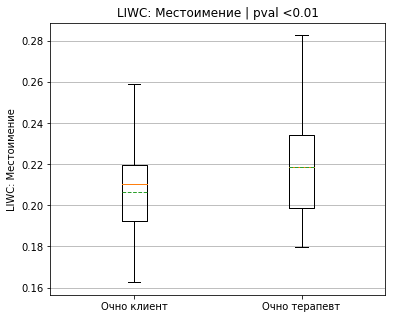

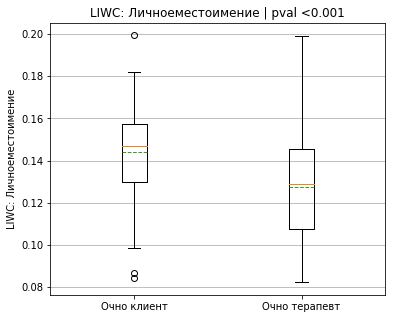

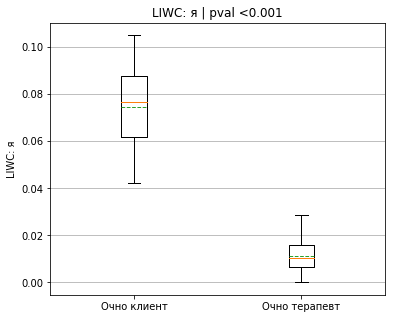

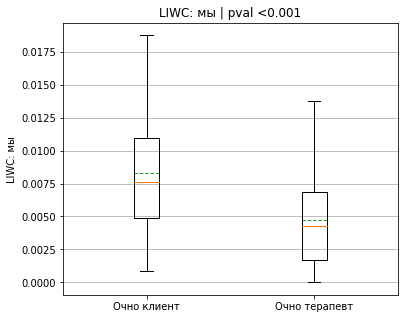

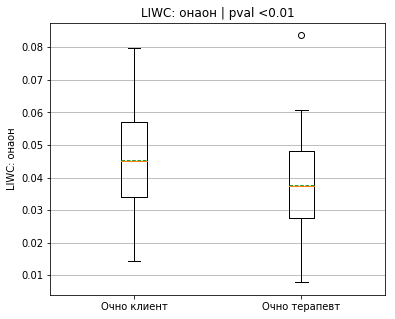

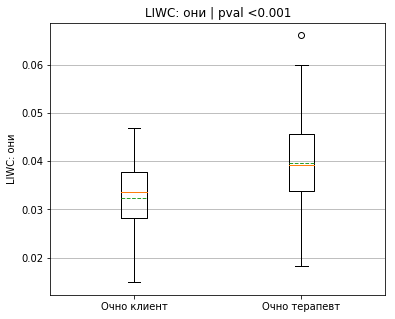

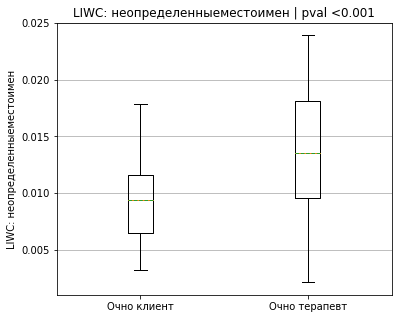

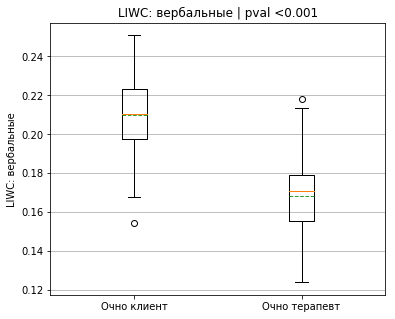

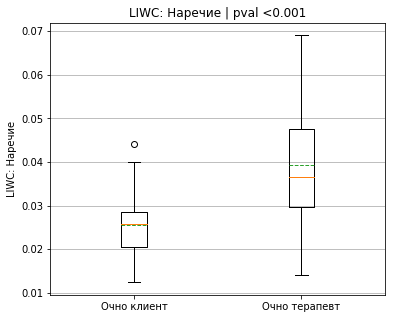

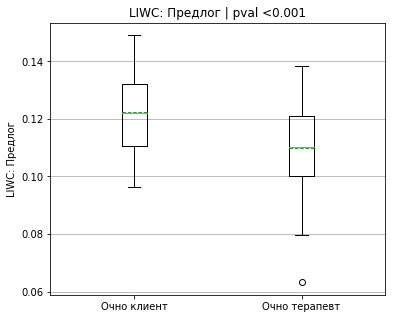

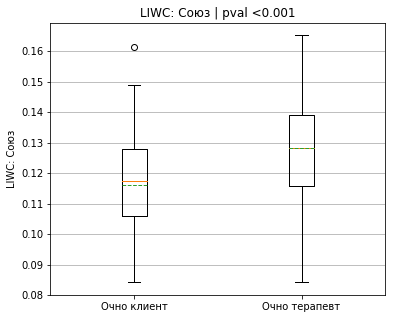

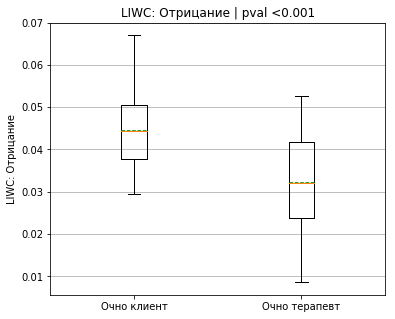

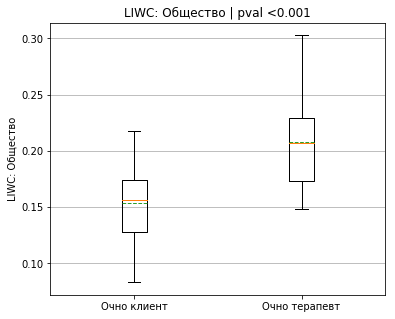

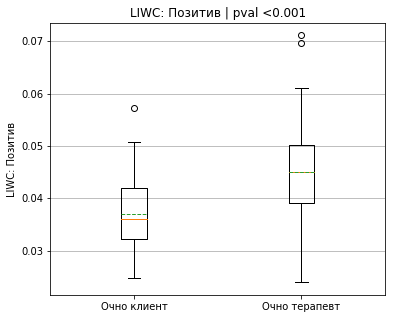

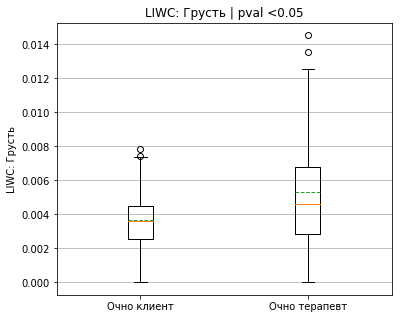

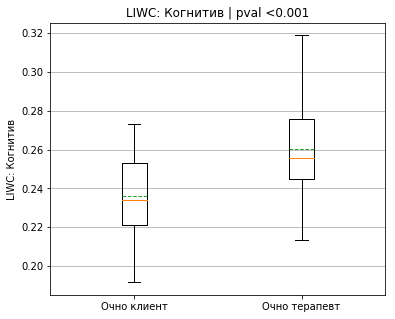

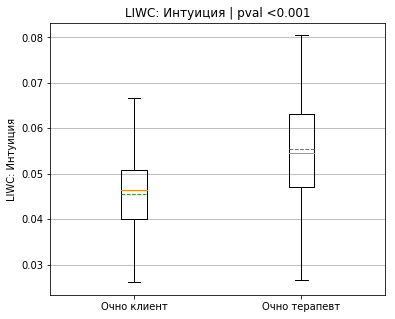

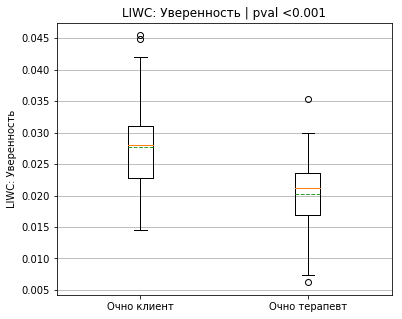

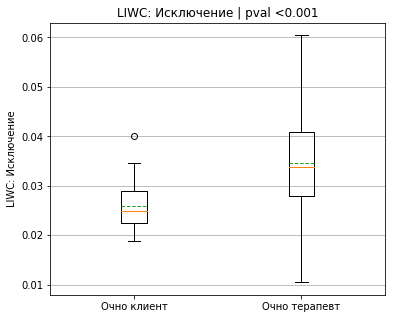

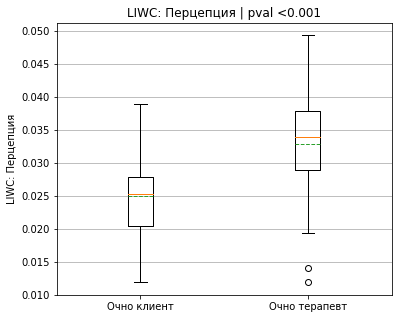

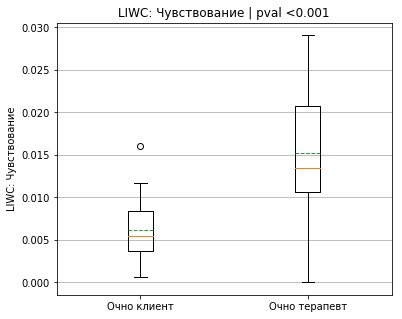

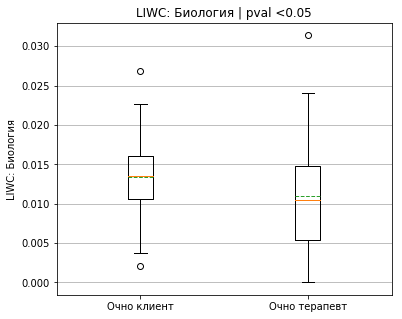

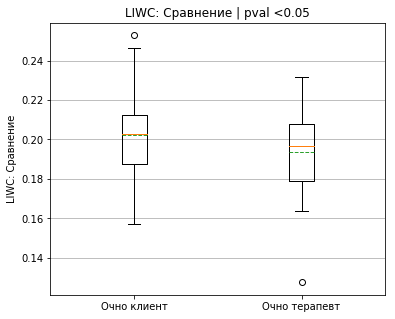

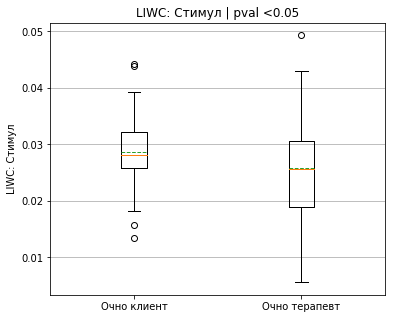

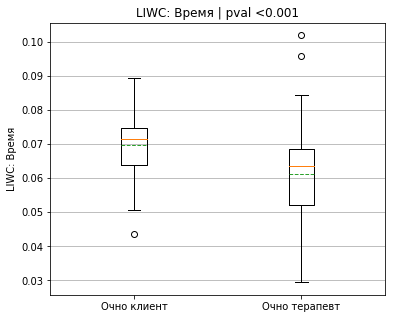

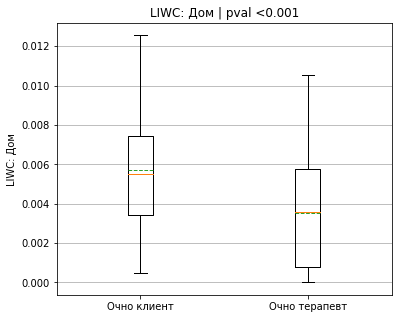

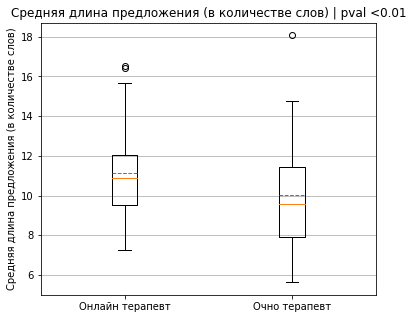

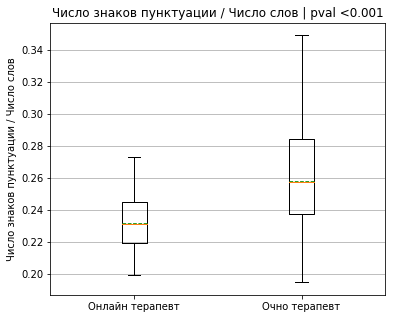

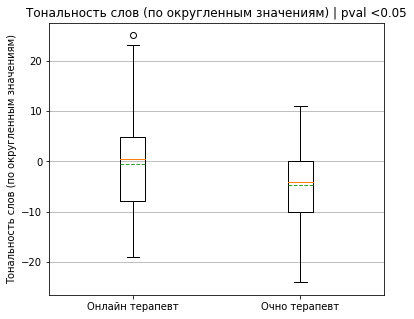

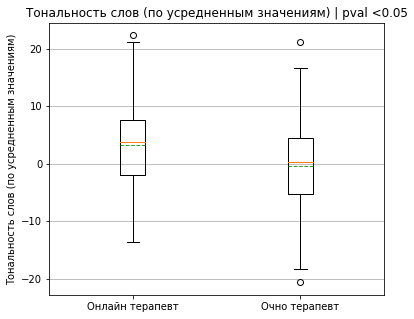

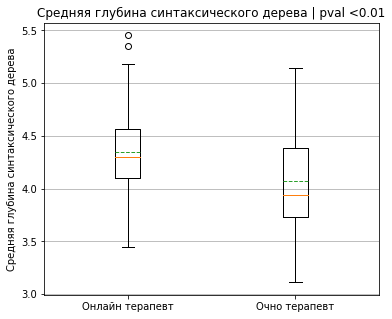

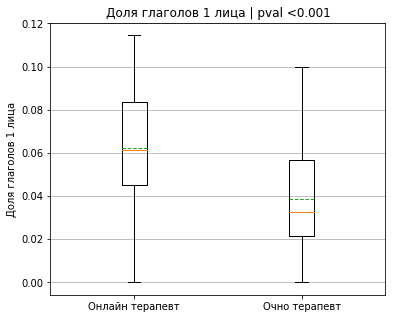

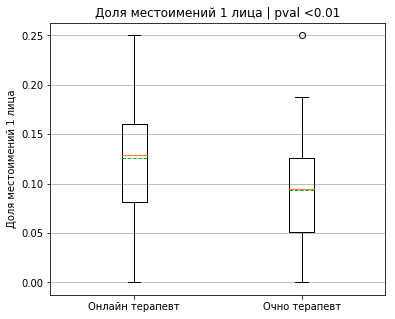

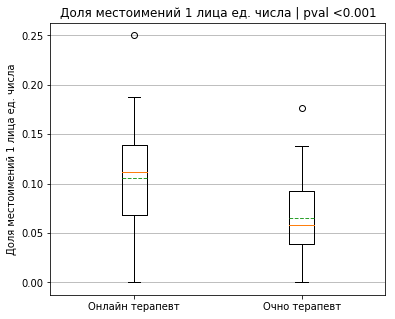

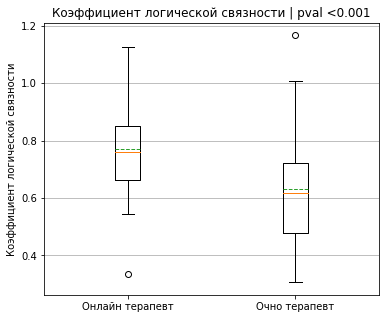

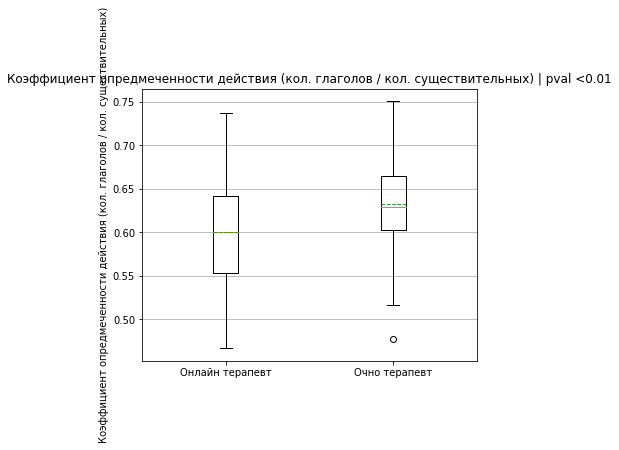

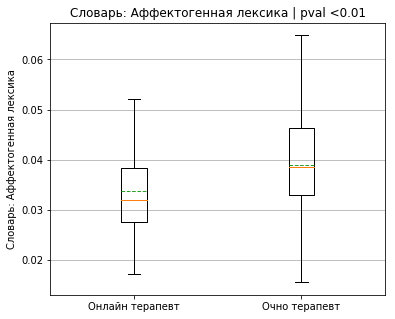

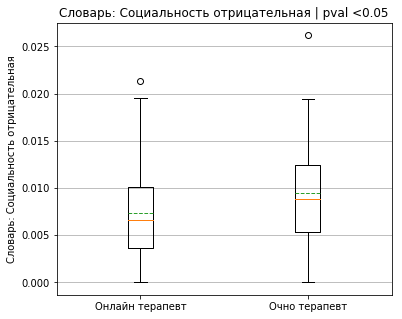

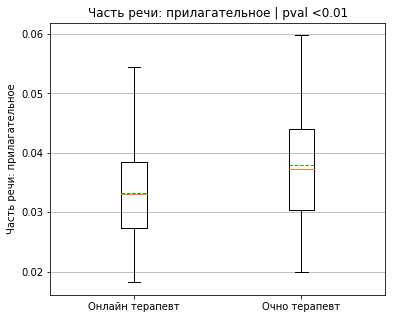

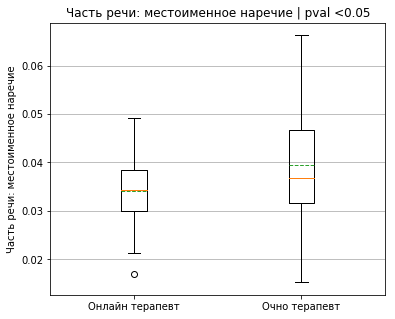

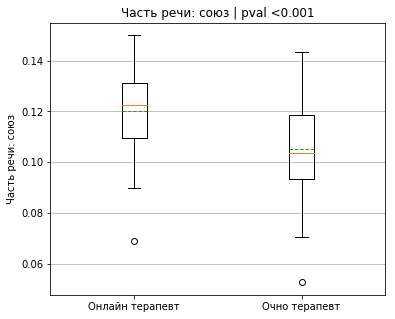

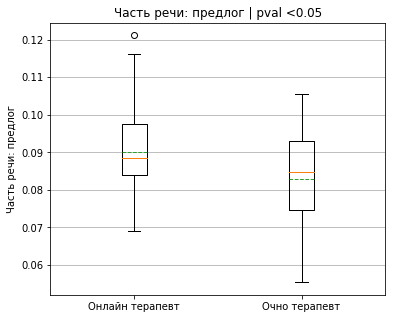

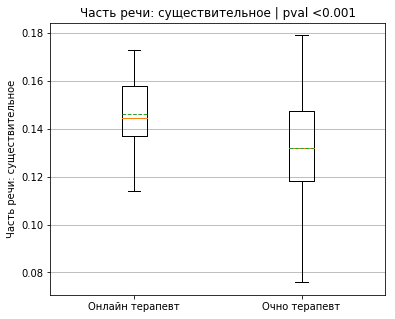

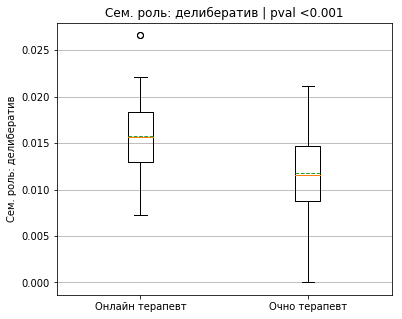

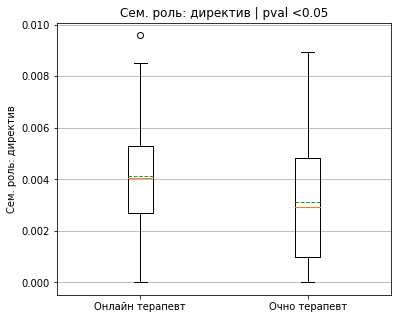

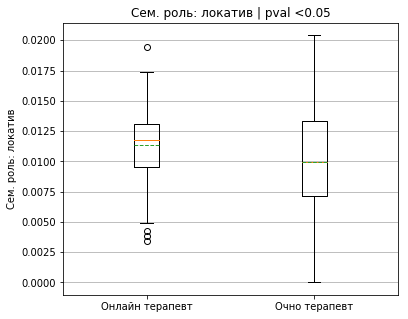

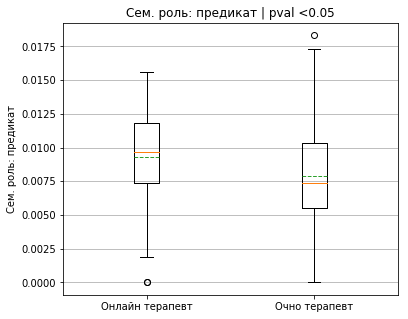

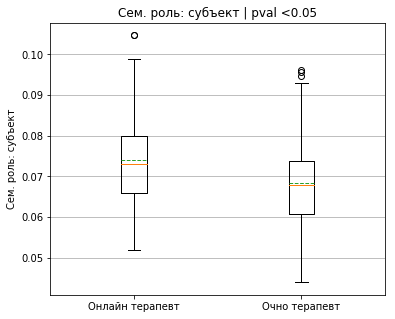

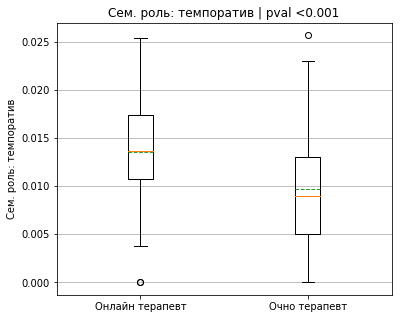

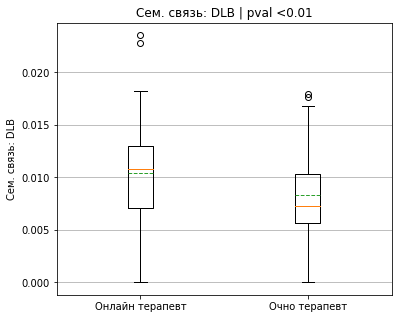

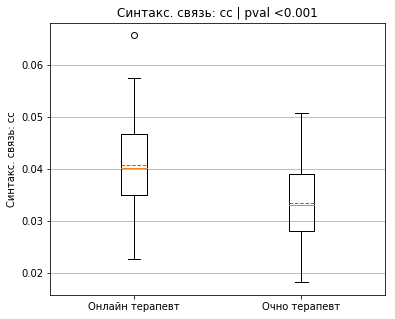

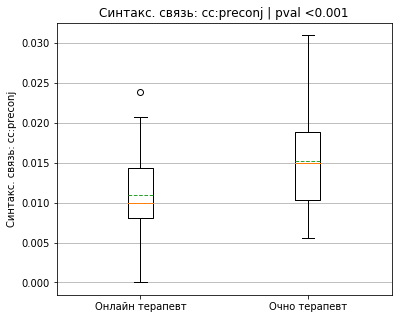

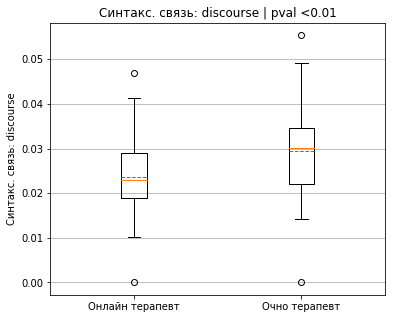

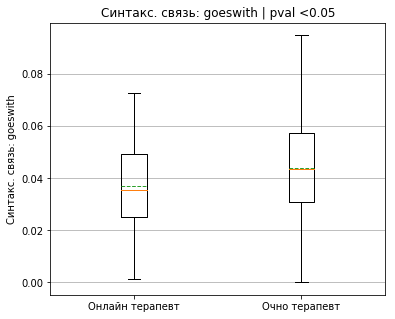

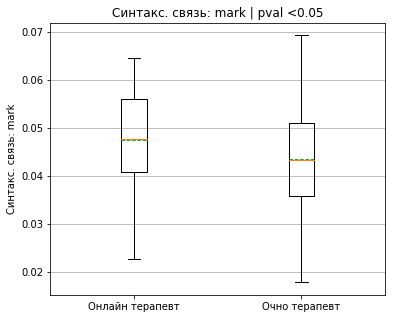

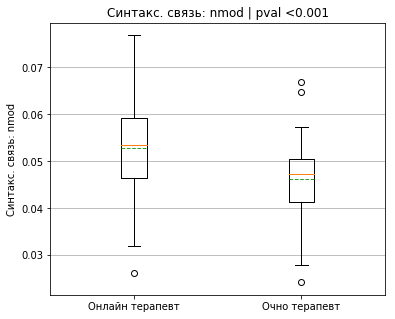

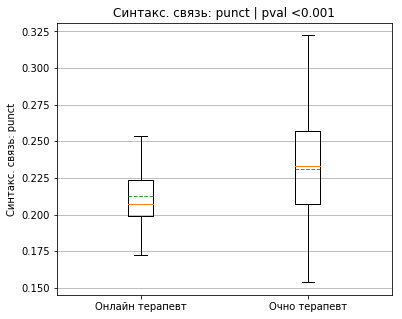

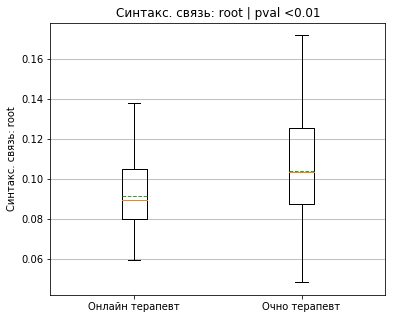

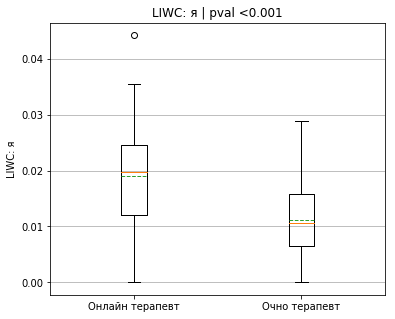

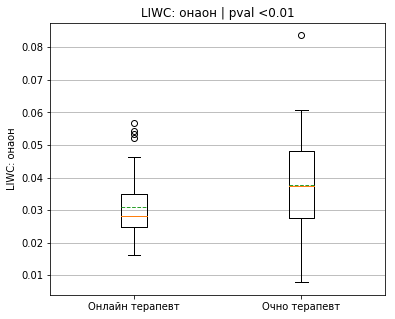

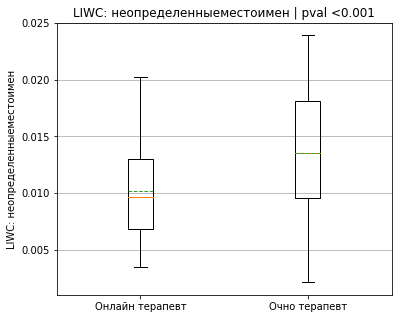

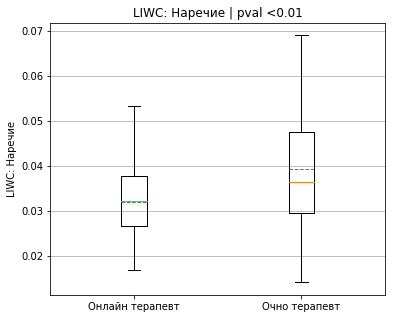

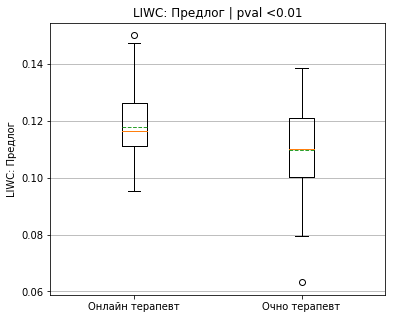

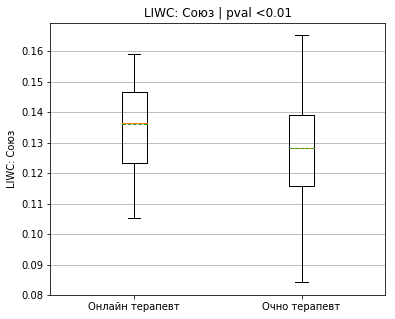

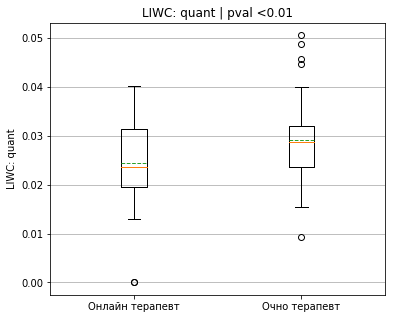

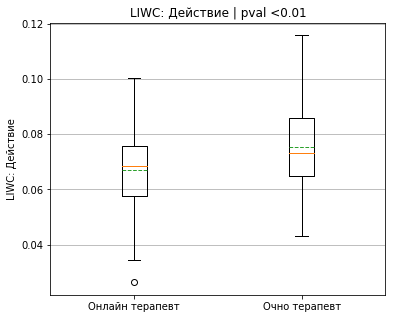

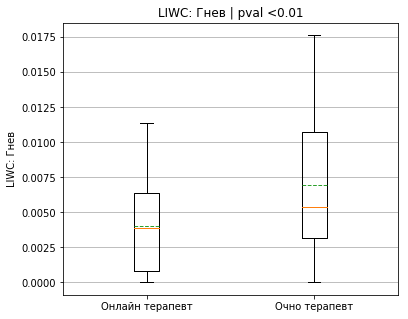

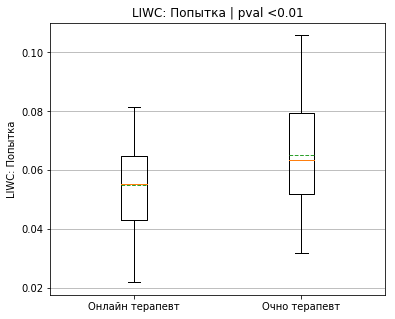

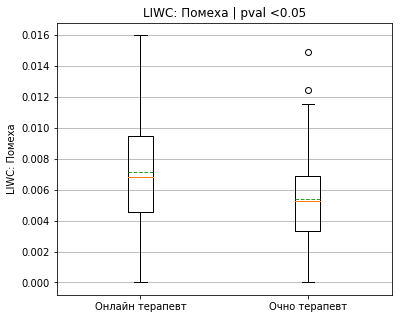

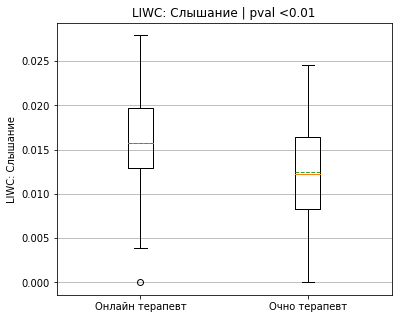

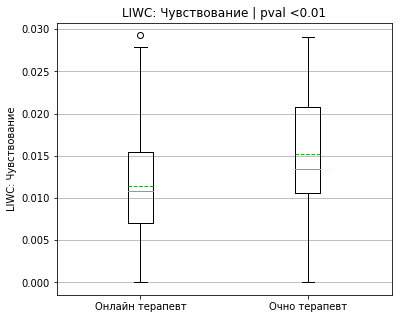

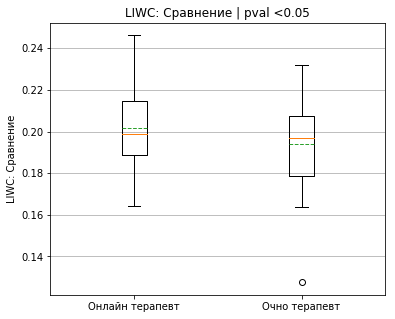

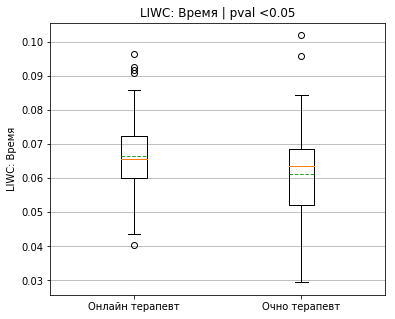

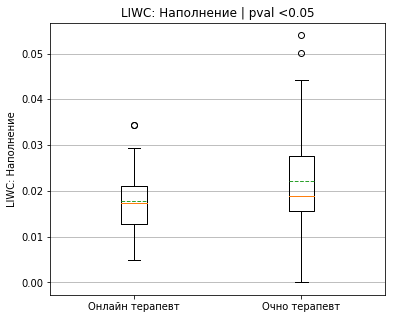

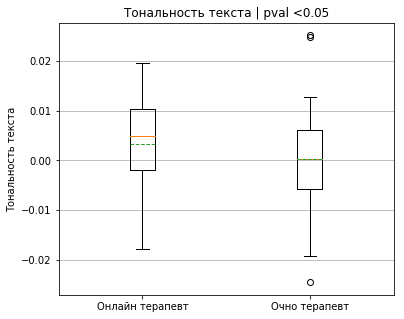

In [161]:
ignore_list = []
features_ignore = ['Доля прописных символов', 'Число знаков препинания']
stat_data = []
for key1 in all_types:
    for key2 in all_types:
        if key1!=key2 and key1+key2 not in ignore_list and key2+key1 not in ignore_list:
            ignore_list.append(key1+key2)
            ignore_list.append(key2+key1)
            for feature in features:
                if feature not in features_ignore:
                    target1 = remove_outliers(all_types[key1][feature].copy())
                    target2 = remove_outliers(all_types[key2][feature].copy())

                    res = {}
                    res['Показатель'] = feature
                    res['Роль 1'] = key1
                    res['Роль 2'] = key2
                    res['Сред. Роль 1'] = target1.mean()
                    res['Сред. Роль 2'] = target2.mean()
                    res['pval mann-whitney'] = ''

                    if normal_dist(target1) and normal_dist(target2):
                        stat,pval = stats.mannwhitneyu(target1.tolist(),target2.tolist())
                        if pval<0.05:
                            res['pval mann-whitney'] = '<0.05'
                            if pval<0.01:
                                res['pval mann-whitney'] = '<0.01'
                            if pval<0.001:
                                res['pval mann-whitney'] = '<0.001'
                            stat_data.append(res)
                            boxplot(data_to_plot=[target1,target2], name1=key1, name2=key2, title=feature)

stat_df = pd.DataFrame(stat_data)
stat_df.sort_values(['Роль 1','Роль 2', 'pval mann-whitney','Показатель'],ascending=True, inplace=True)

In [162]:
writer = pd.ExcelWriter('4 группы.xlsx', engine='xlsxwriter')
df_PM.to_excel(writer, sheet_name='Маркеры', index=False)
df_PM_abs.to_excel(writer, sheet_name='Маркеры (абсолютные значения)', index=False)
stat_df.to_excel(writer, sheet_name='Тест Манна-Уитни', index=False)
writer.save()

In [163]:
stat_df

Показатель         Роль 1  \
112                                 LIWC: quant  Онлайн клиент   
115                              LIWC: Интуиция  Онлайн клиент   
120                            LIWC: Исключение  Онлайн клиент   
103                           LIWC: Местоимение  Онлайн клиент   
116                             LIWC: Мотивация  Онлайн клиент   
..                                          ...            ...   
341                      Синтакс. связь: nummod    Очно клиент   
313  Словарь: Рациональная оценка положительная    Очно клиент   
315         Словарь: Социальность отрицательная    Очно клиент   
318                         Часть речи: наречие    Очно клиент   
317                  Часть речи: прилагательное    Очно клиент   

              Роль 2  Сред. Роль 1  Сред. Роль 2 pval mann-whitney  
112  Онлайн терапевт      0.030372      0.024485            <0.001  
115  Онлайн терапевт      0.046283      0.052997            <0.001  
120  Онлайн терапевт      0.025795      0.036751            <0.001  
103  Онлайн терапевт      0.199586      0.211029            <0.001  
116  Онлайн терапевт      0.026898      0.035107            <0.001  
..               ...           ...           ...               ...  
341    Очно терапевт      0.003164      0.002625             <0.05  
313    Очно терапевт      0.021608      0.024751             <0.05  
315    Очно терапевт      0.007578      0.009438             <0.05  
318    Очно терапевт      0.072706      0.076716             <0.05  
317    Очно терапевт      0.035009      0.037996             <0.05  

[421 rows x 6 columns]